In [1]:
import sys; sys.path.insert(0, '../src')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import twopass
import changepoints
import tests

plt.rcParams["figure.figsize"] = [8, 3]  # width, height
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['xtick.direction'] = 'in'
ids = changepoints.getIds()
eventLog = changepoints.readEventLog()
machineSet = list(changepoints.getMachines(eventLog))

C:\Python38\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [52]:
def metricsMachineRuptures(machine, pen, window, algo, graph = False):
    resbyday, logbyday = tests.checkPointsForMachine(name=machine, eventlog=eventLog, ids=ids, influx=False, wirkl_only=True, n_bkps=None, pen=pen, window=window, algo=algo, model="l2", debug=False)
    res = []
    for x in resbyday:
        daywiseX = []
        for y in x:
            daywiseX.append(y)
            #daywiseX.append(y[1])
        res.append(daywiseX)

    metrics = tests.calculateMetrics(res, logbyday, start = True, end = True, customMargin=60)

    labels = list(map(lambda x: str(x["day"]), metrics))
    precision = list(map(lambda x: x["TP"] / (x["TP"] + x["FP"]), metrics))
    recall = list(map(lambda x: x["TP"] / (x["TP"] + x["FN"]), metrics))

    

    if(graph):

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, precision, width, label='Prec.')
        rects2 = ax.bar(x + width/2, recall, width, label='Recall')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by Day for ' + machine + " on " + algo)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()

    return metrics, precision, recall

In [48]:
good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
algos = ["Window", "Binseg", "Botup"]

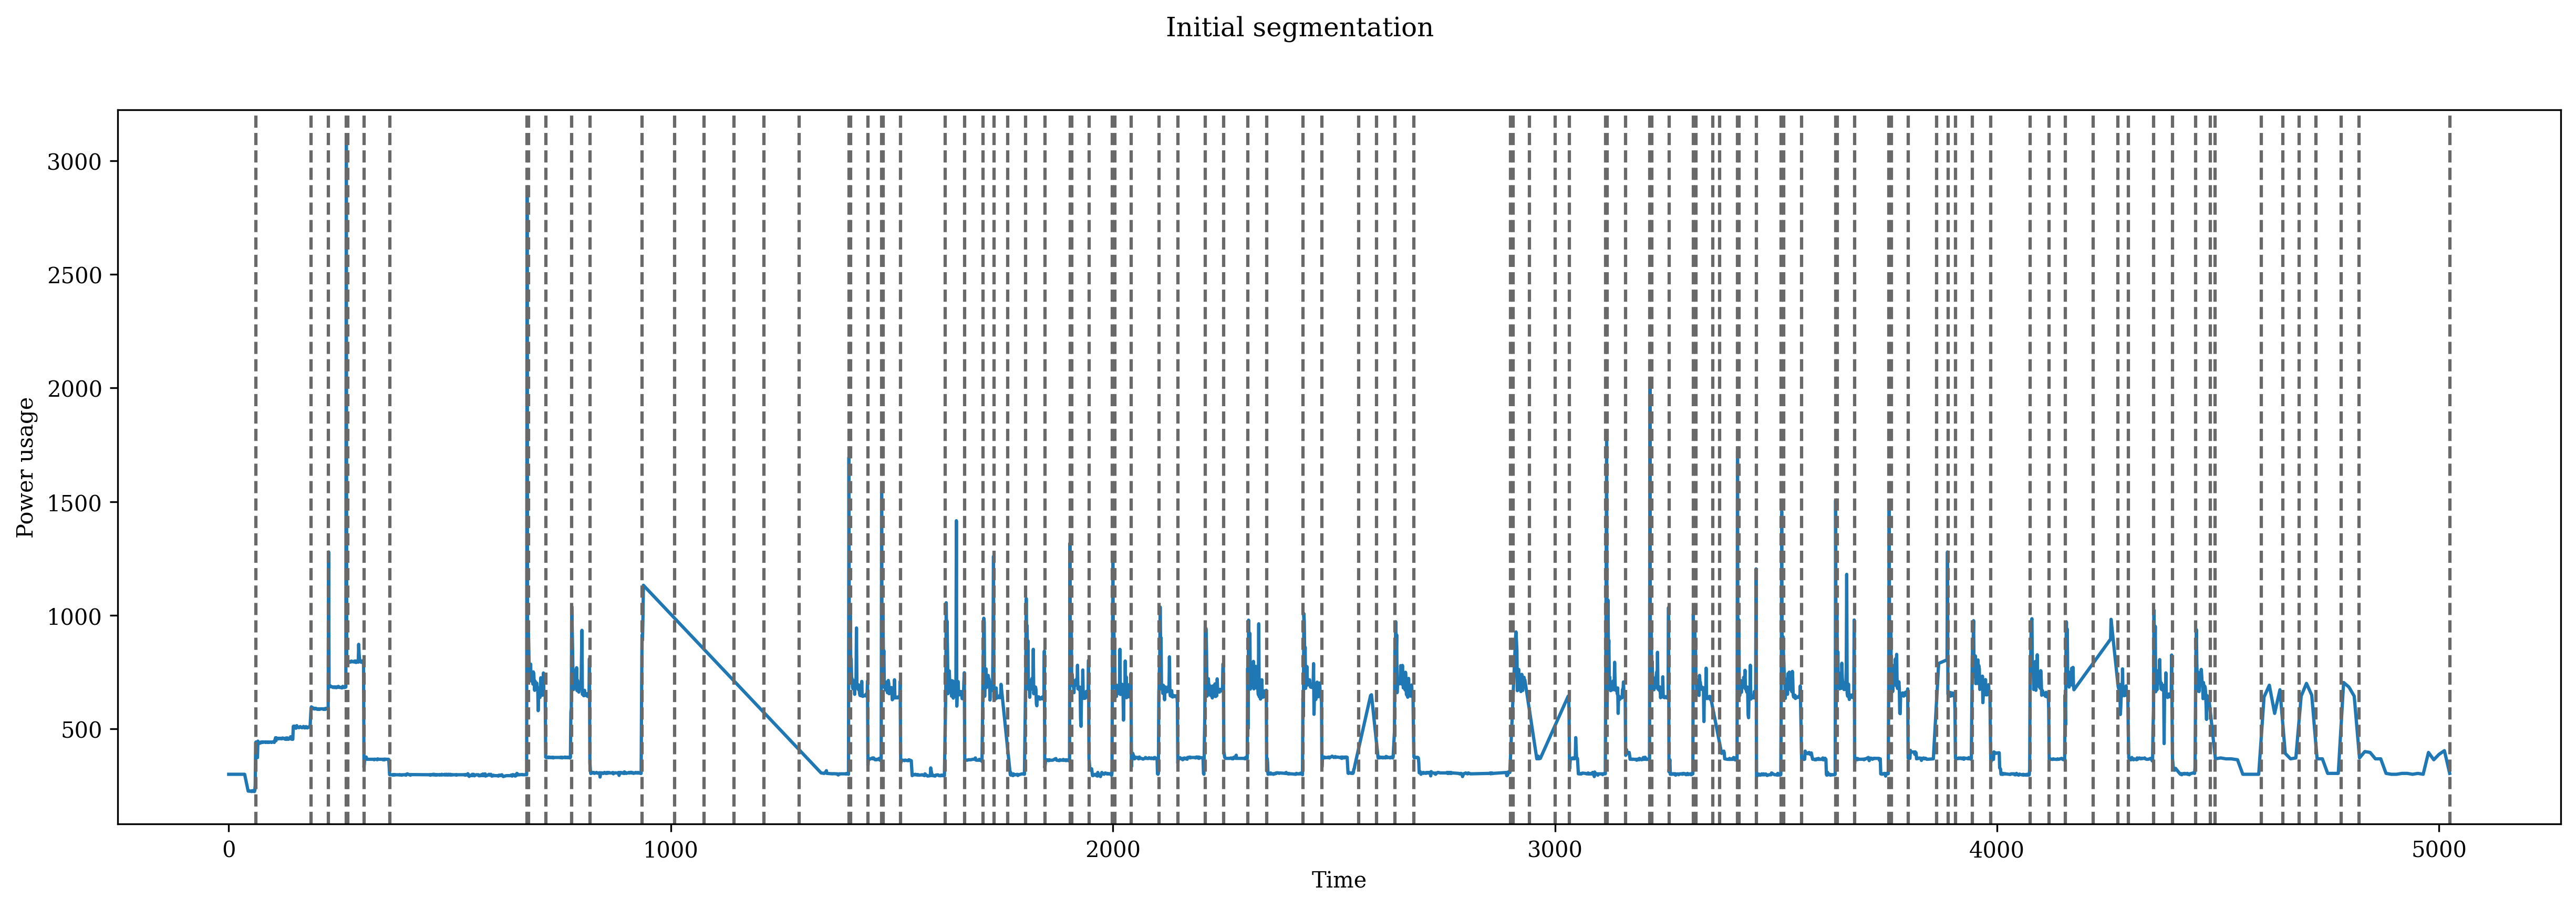

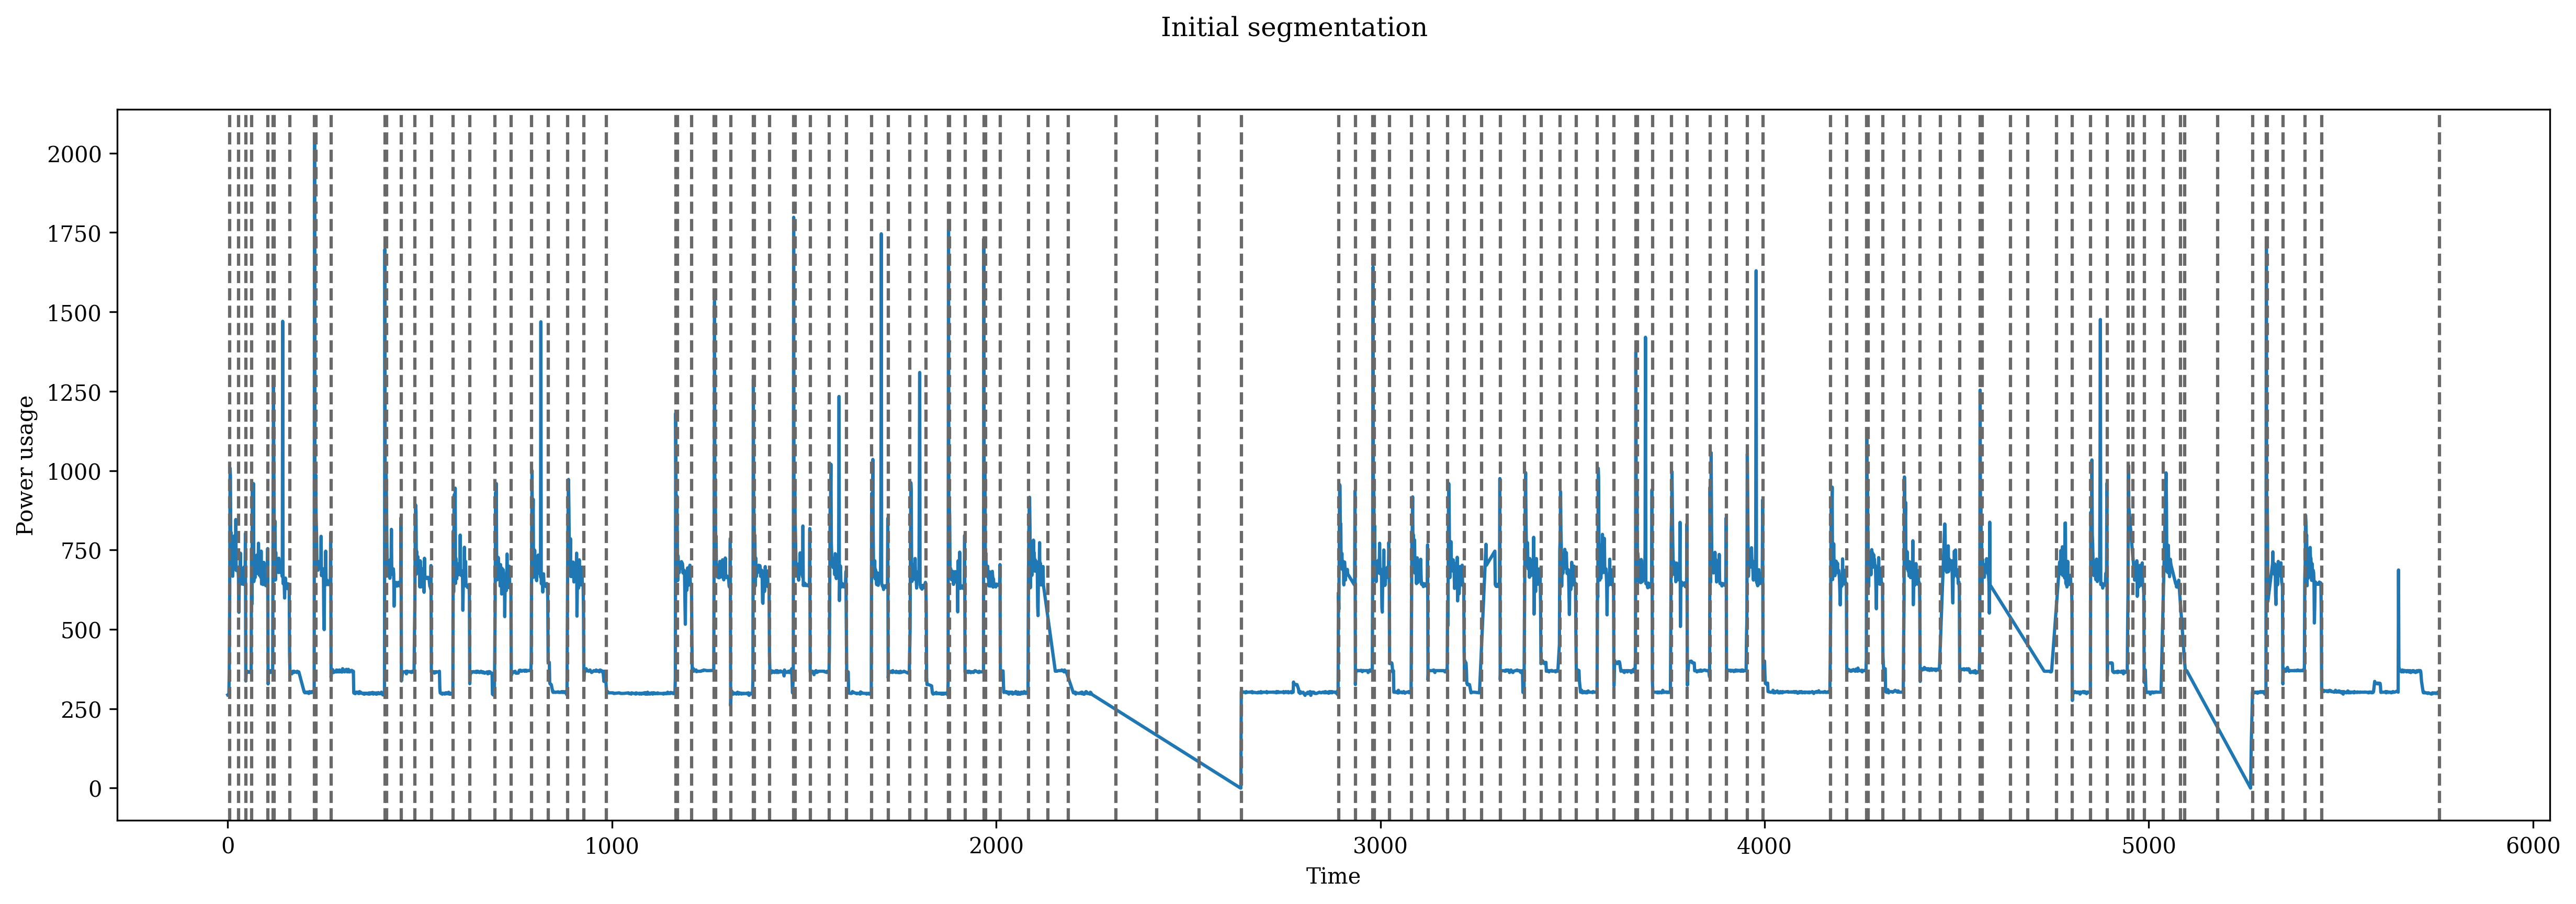

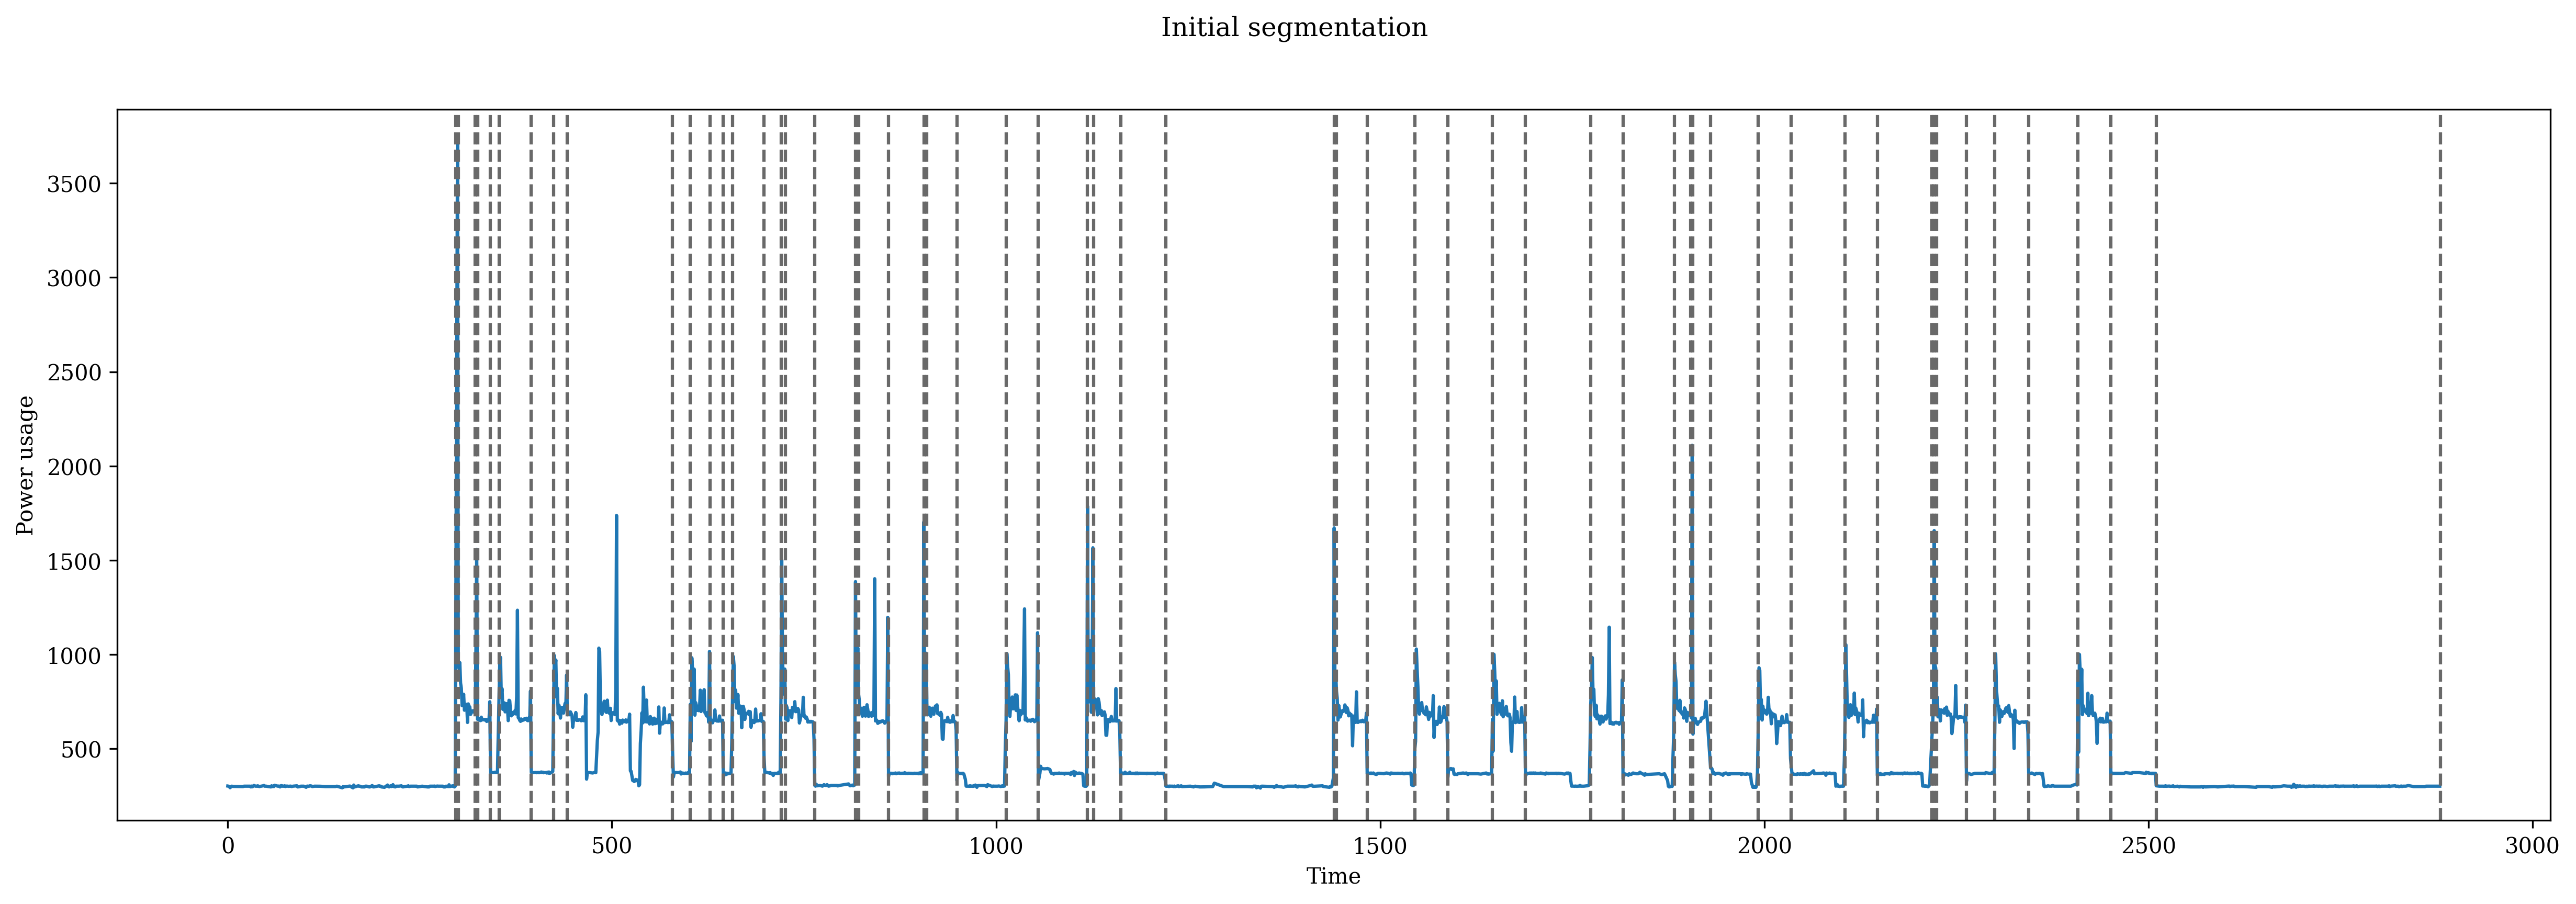

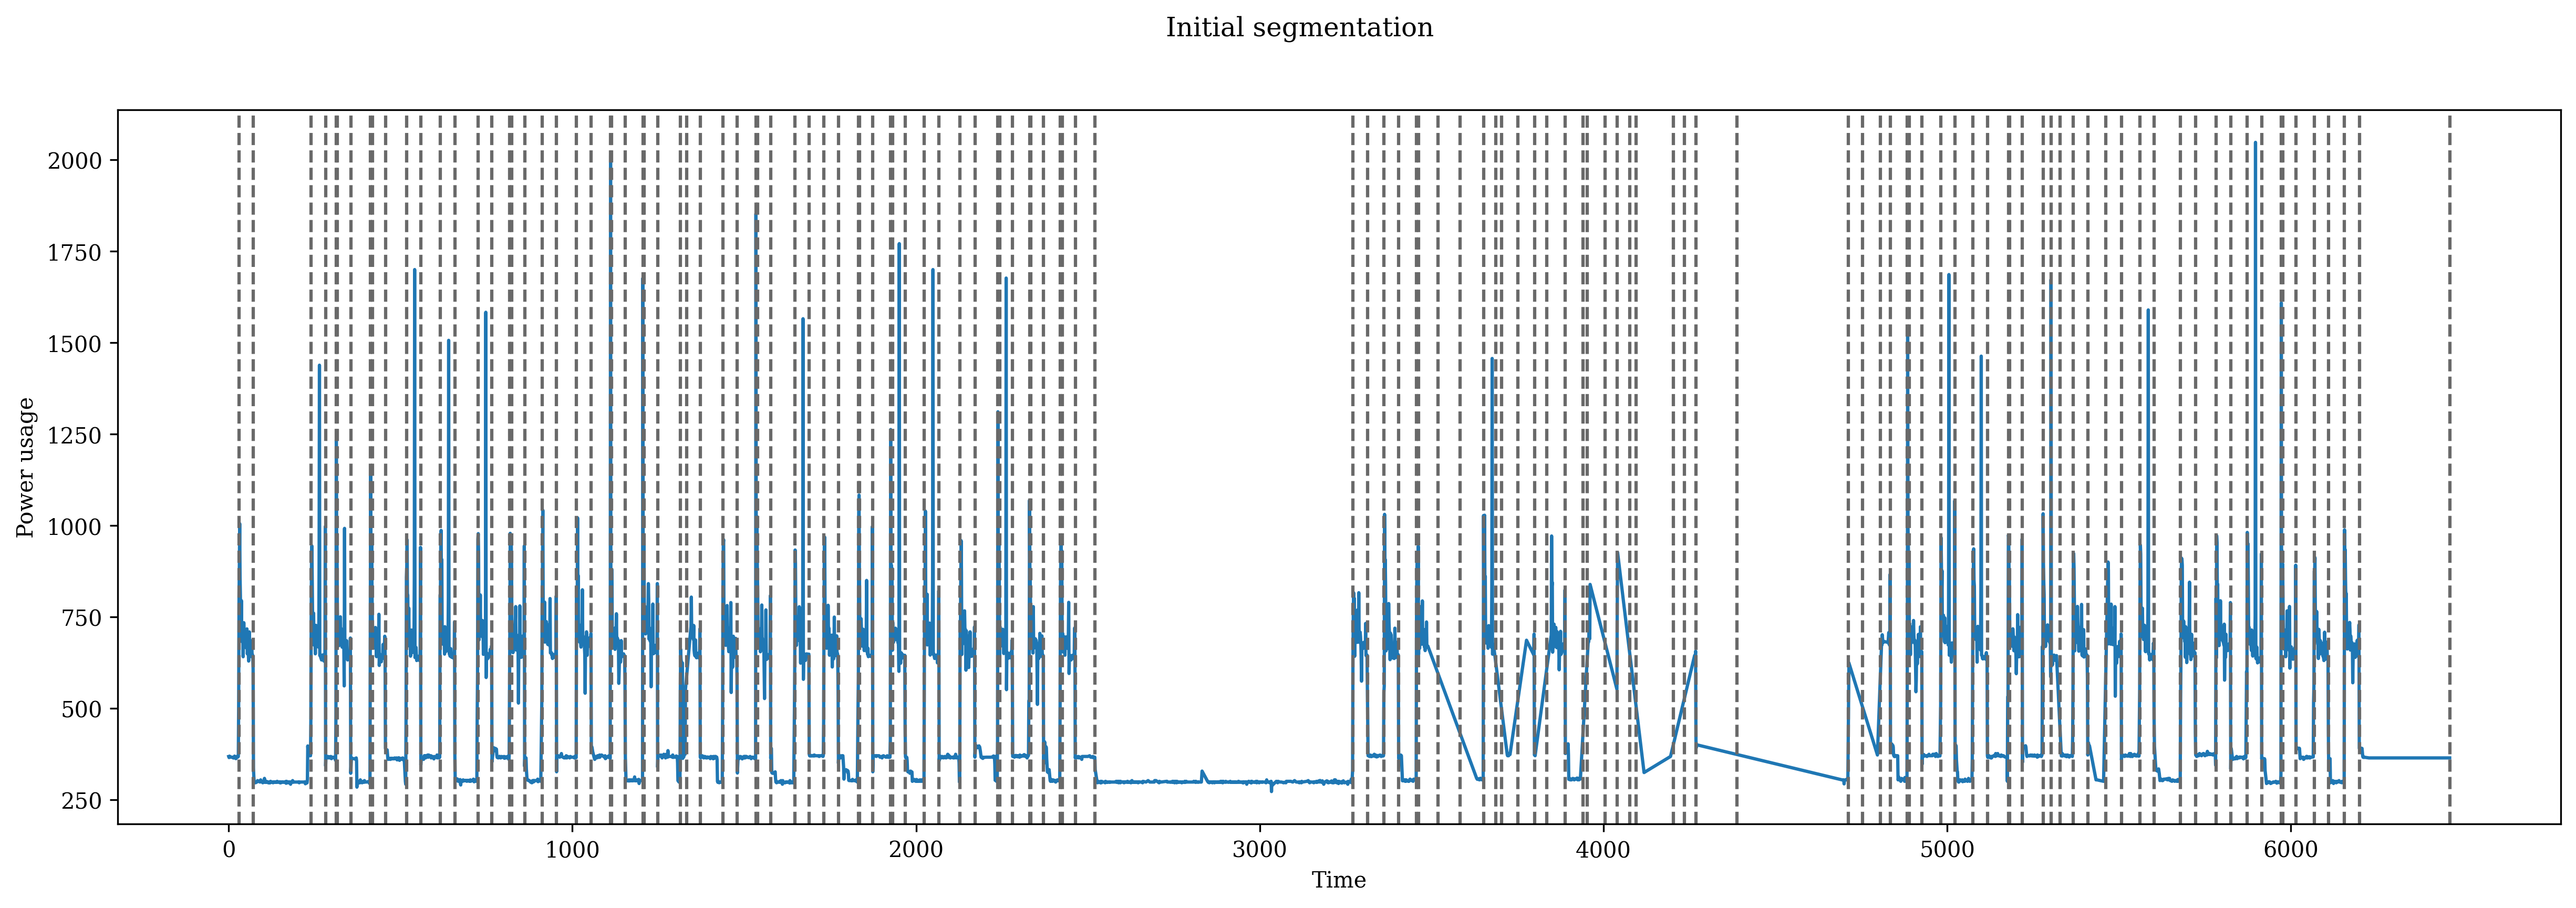

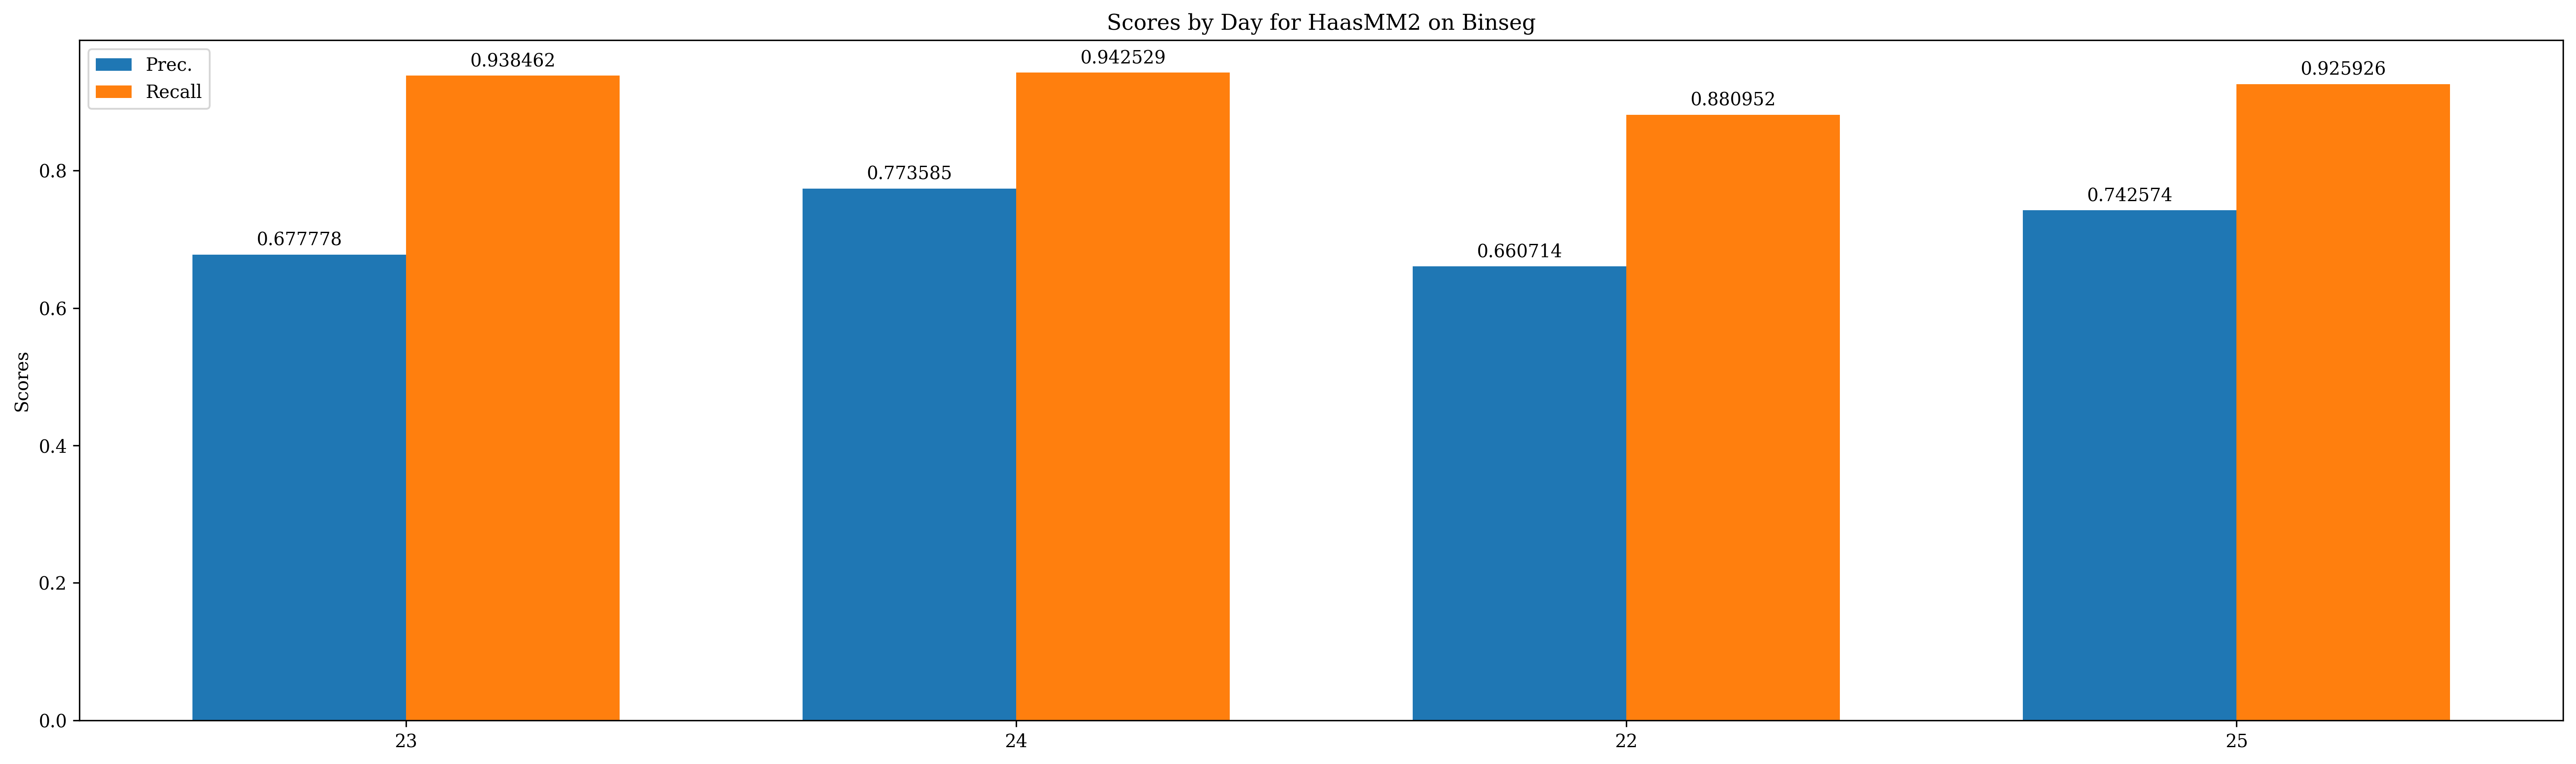

0.8045507600895522 0.7136628066445458 0.9219671452430073


In [53]:
_,prec,recall = metricsMachineRuptures(machine="HaasMM2", pen=200000, window=35, algo="Binseg", graph = True)
totalprec = sum(prec)/len(prec)
totalrecall = sum(recall)/len(recall)
totalf1 = 2 * (totalprec * totalrecall) / (totalprec + totalrecall)
print(totalf1, totalprec, totalrecall)

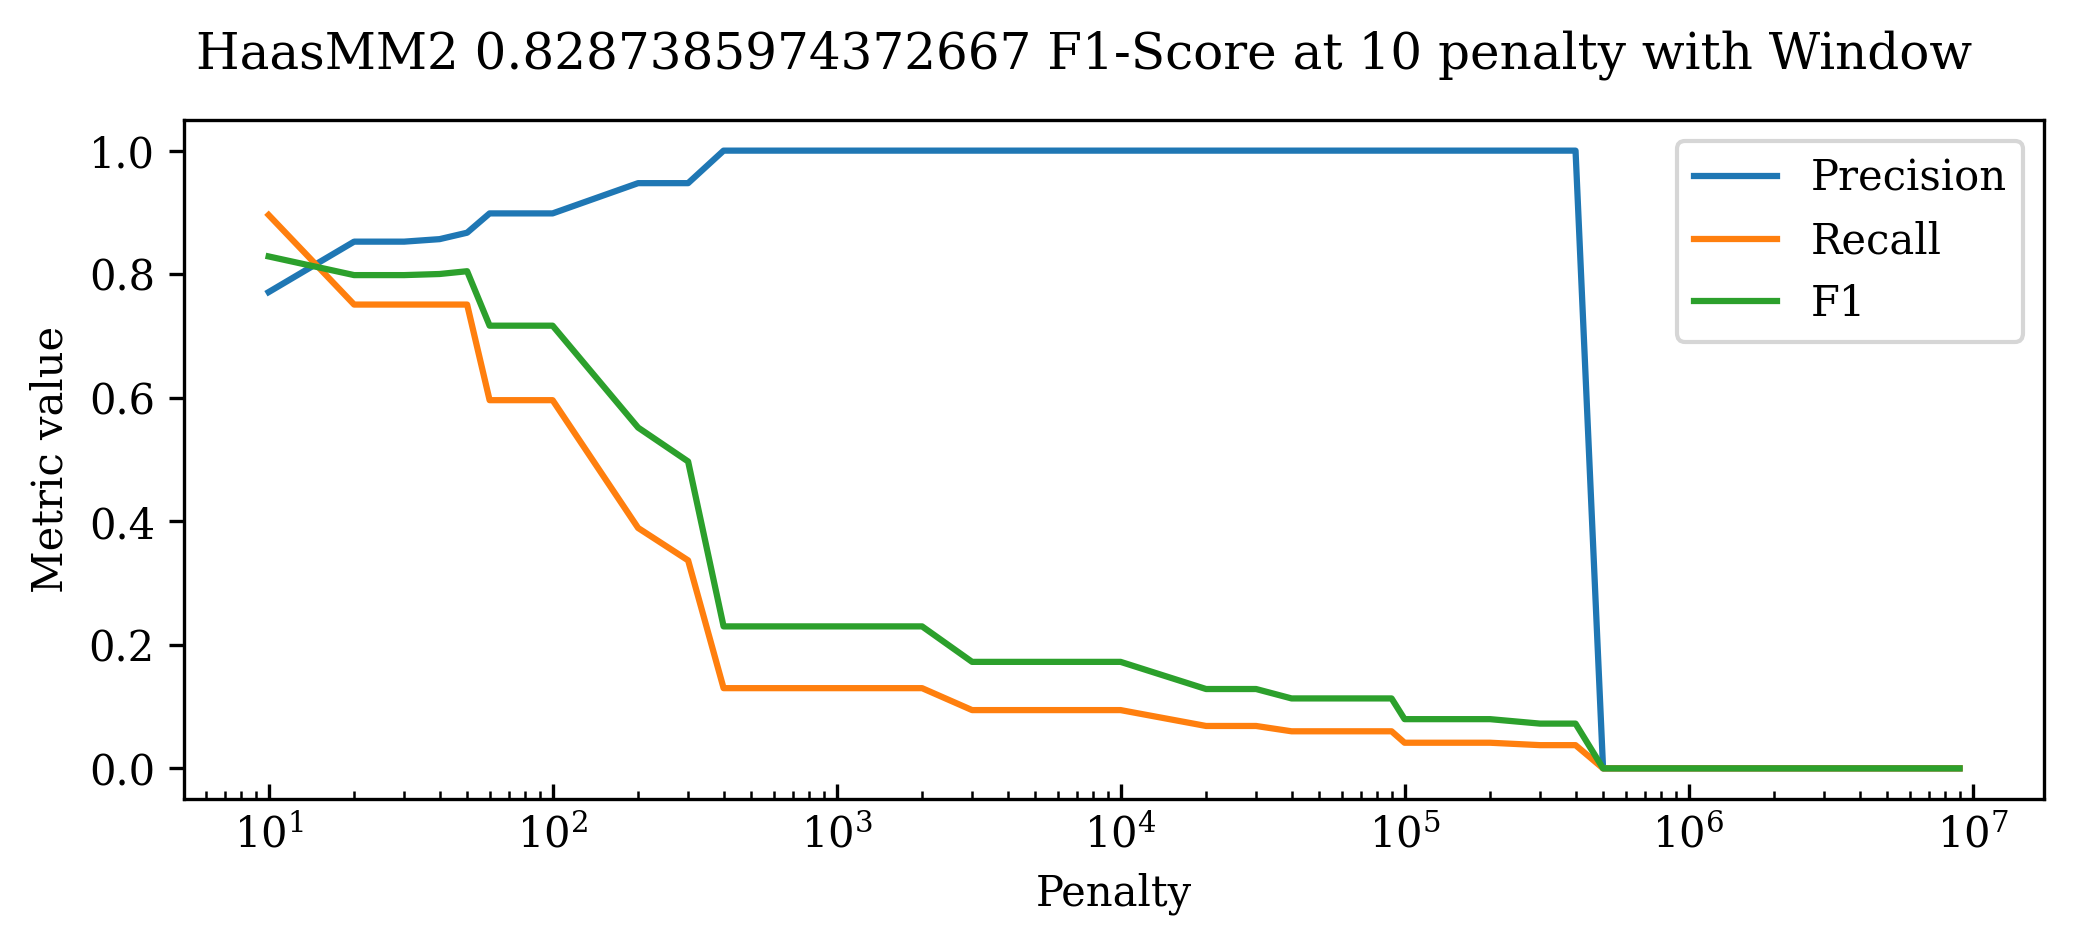

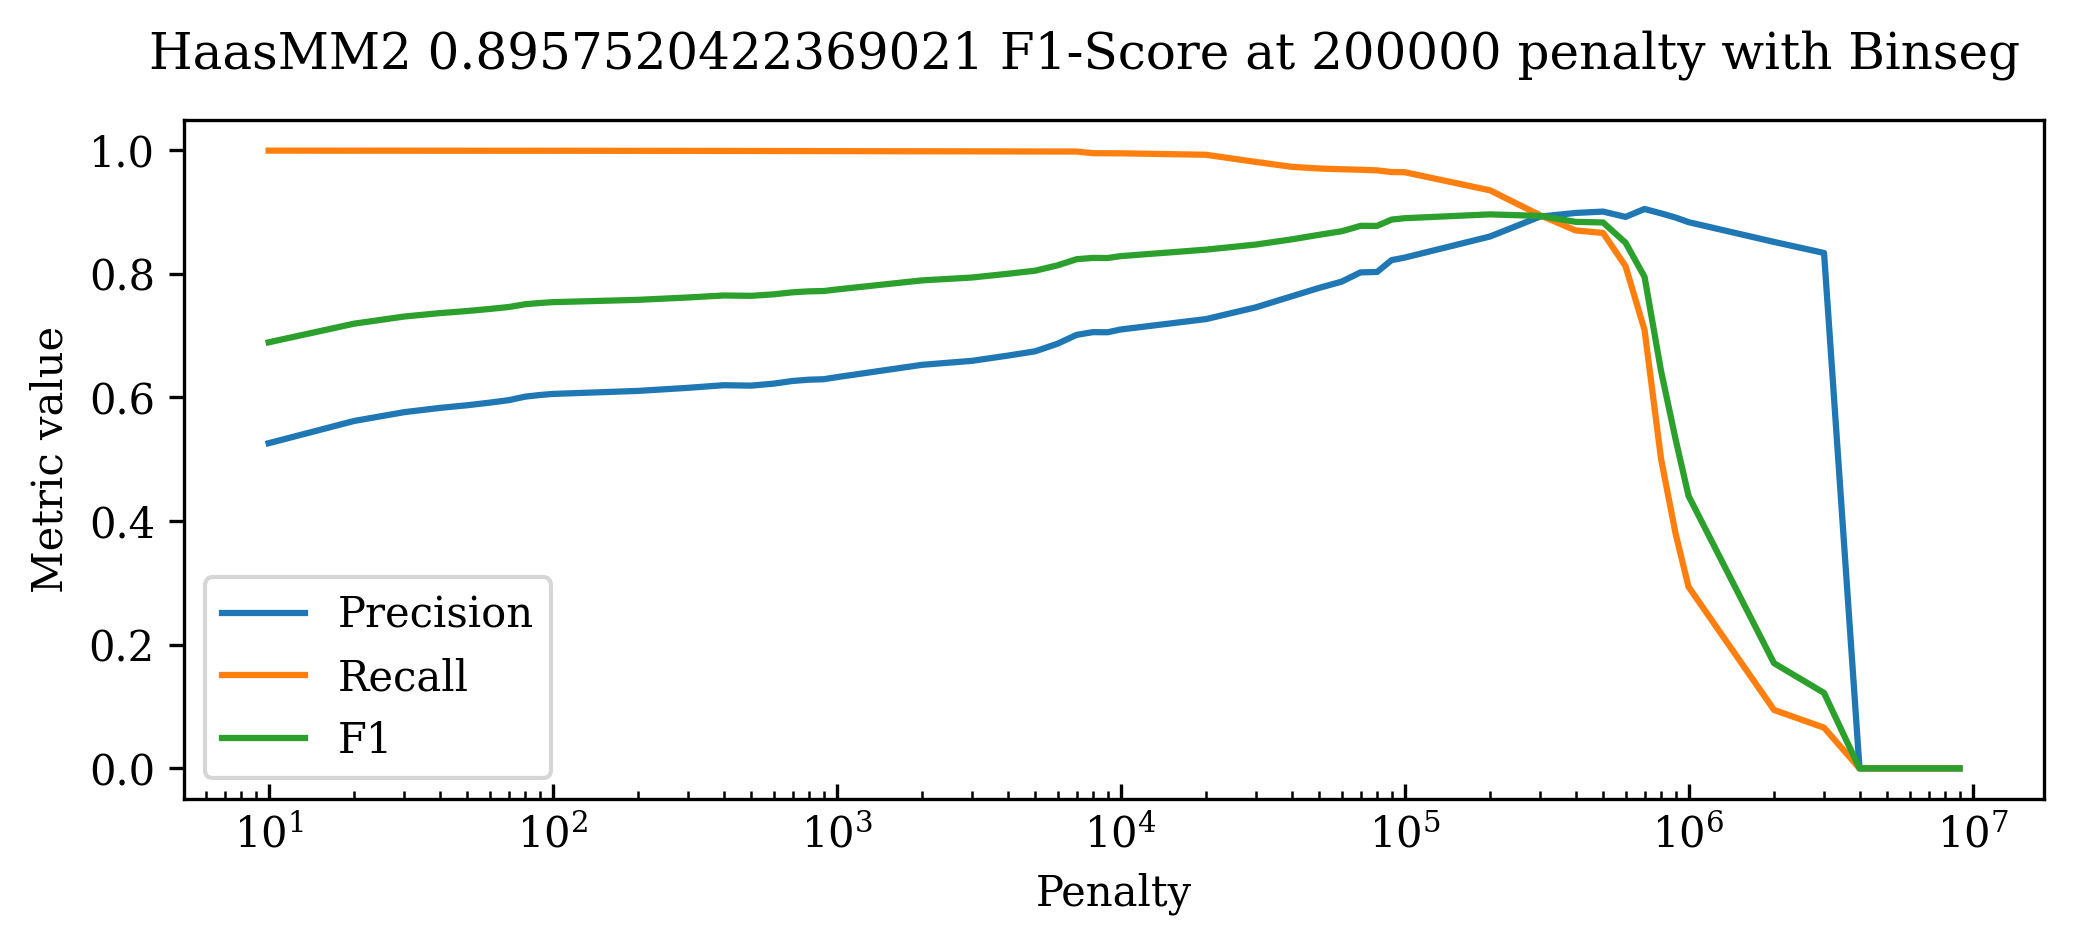

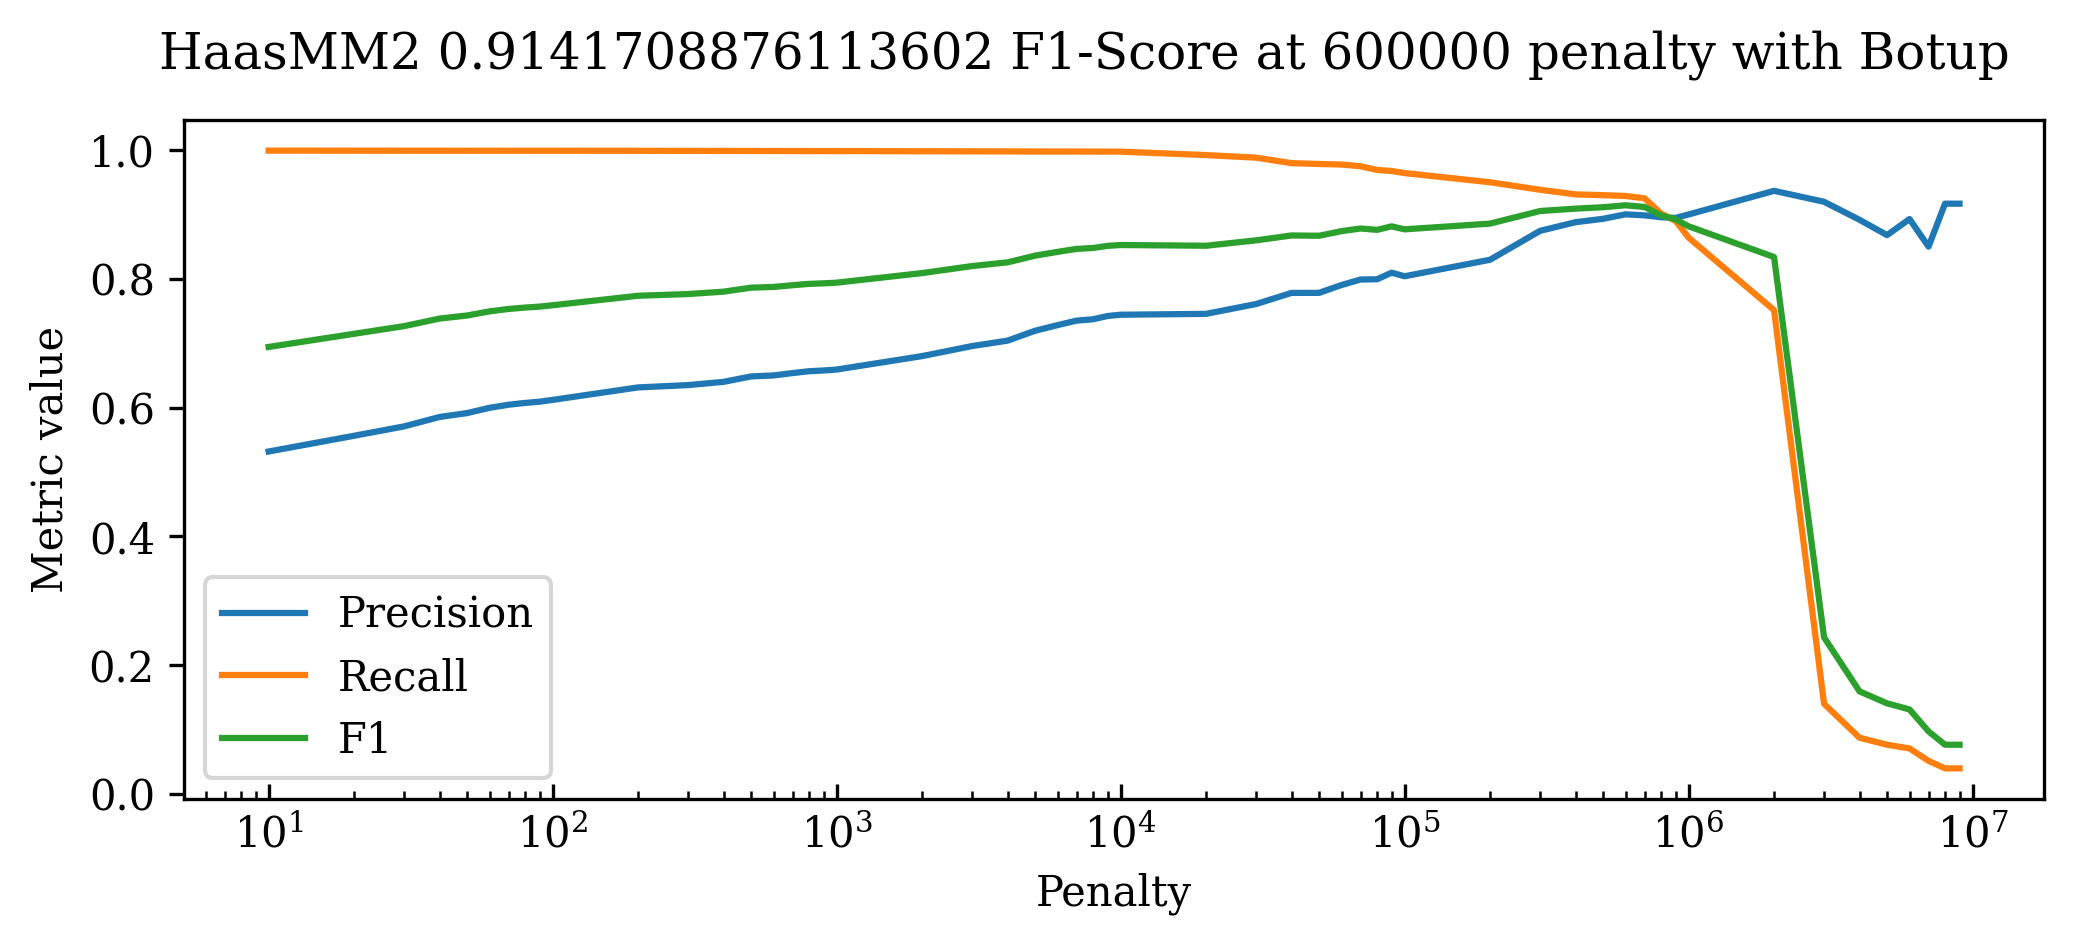

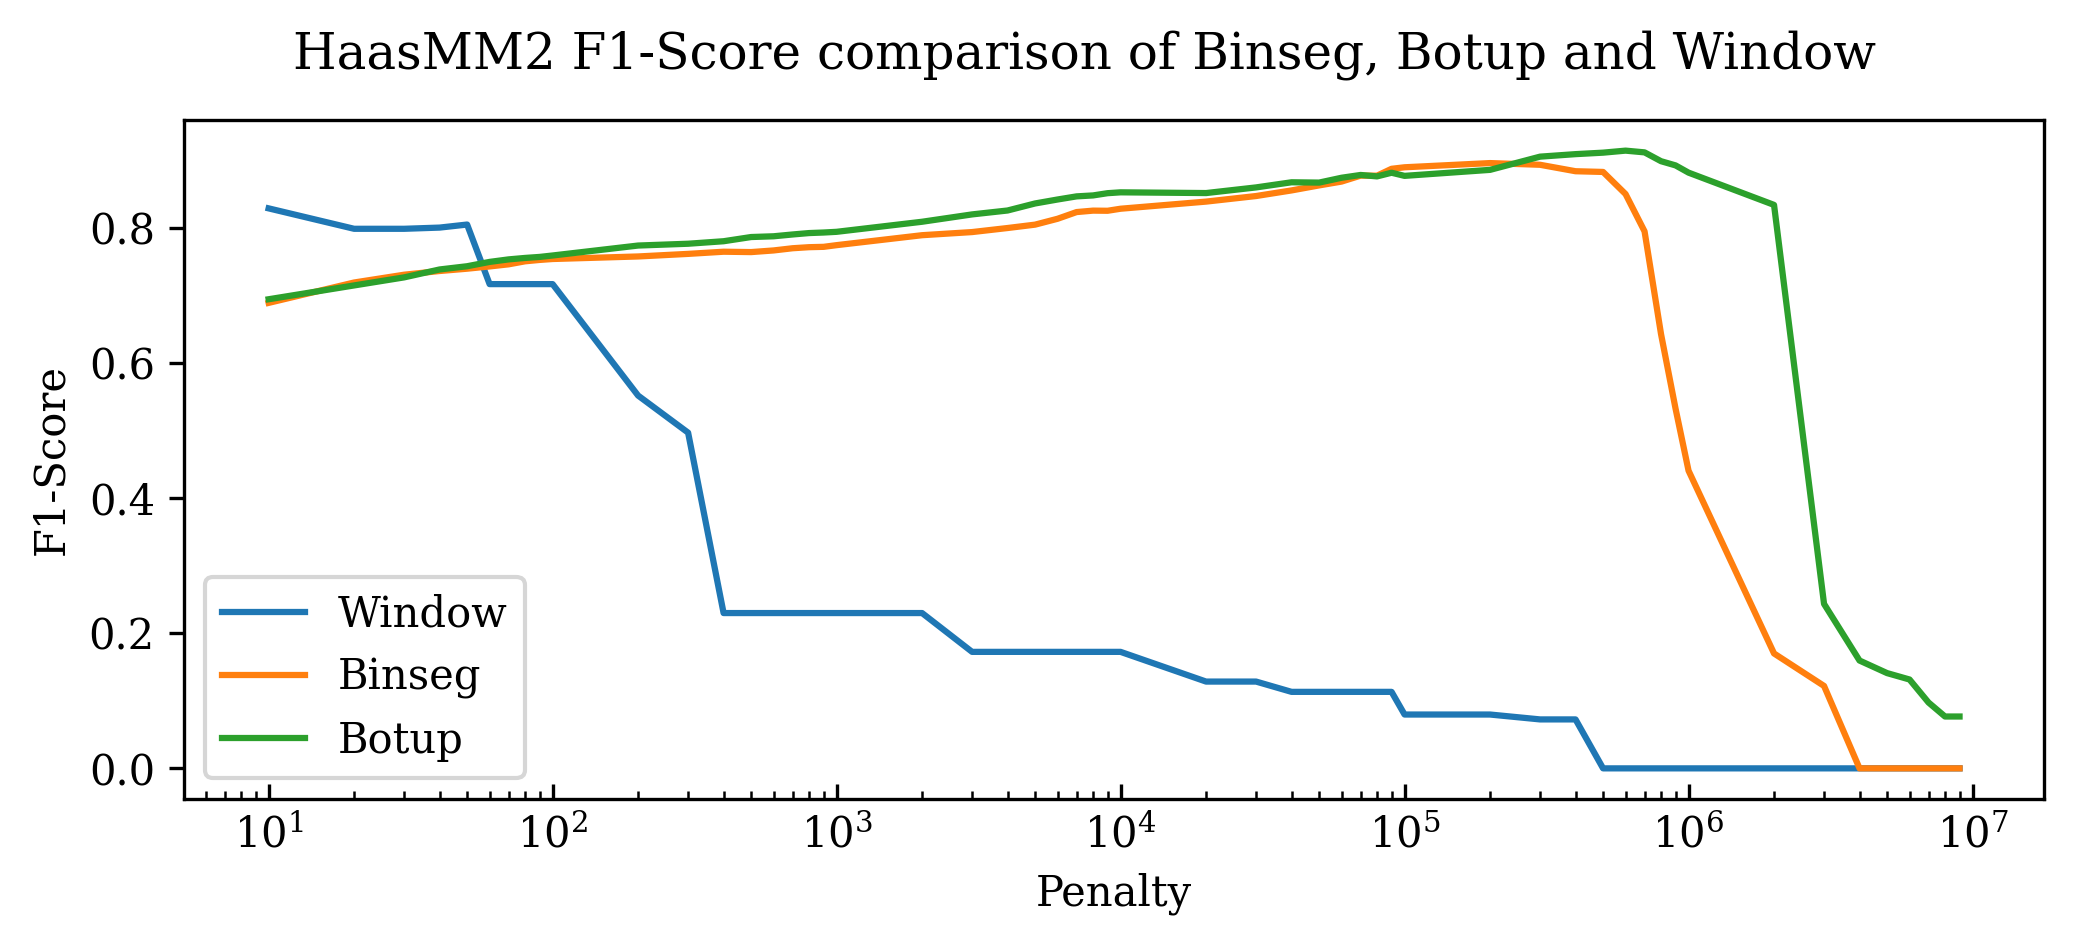

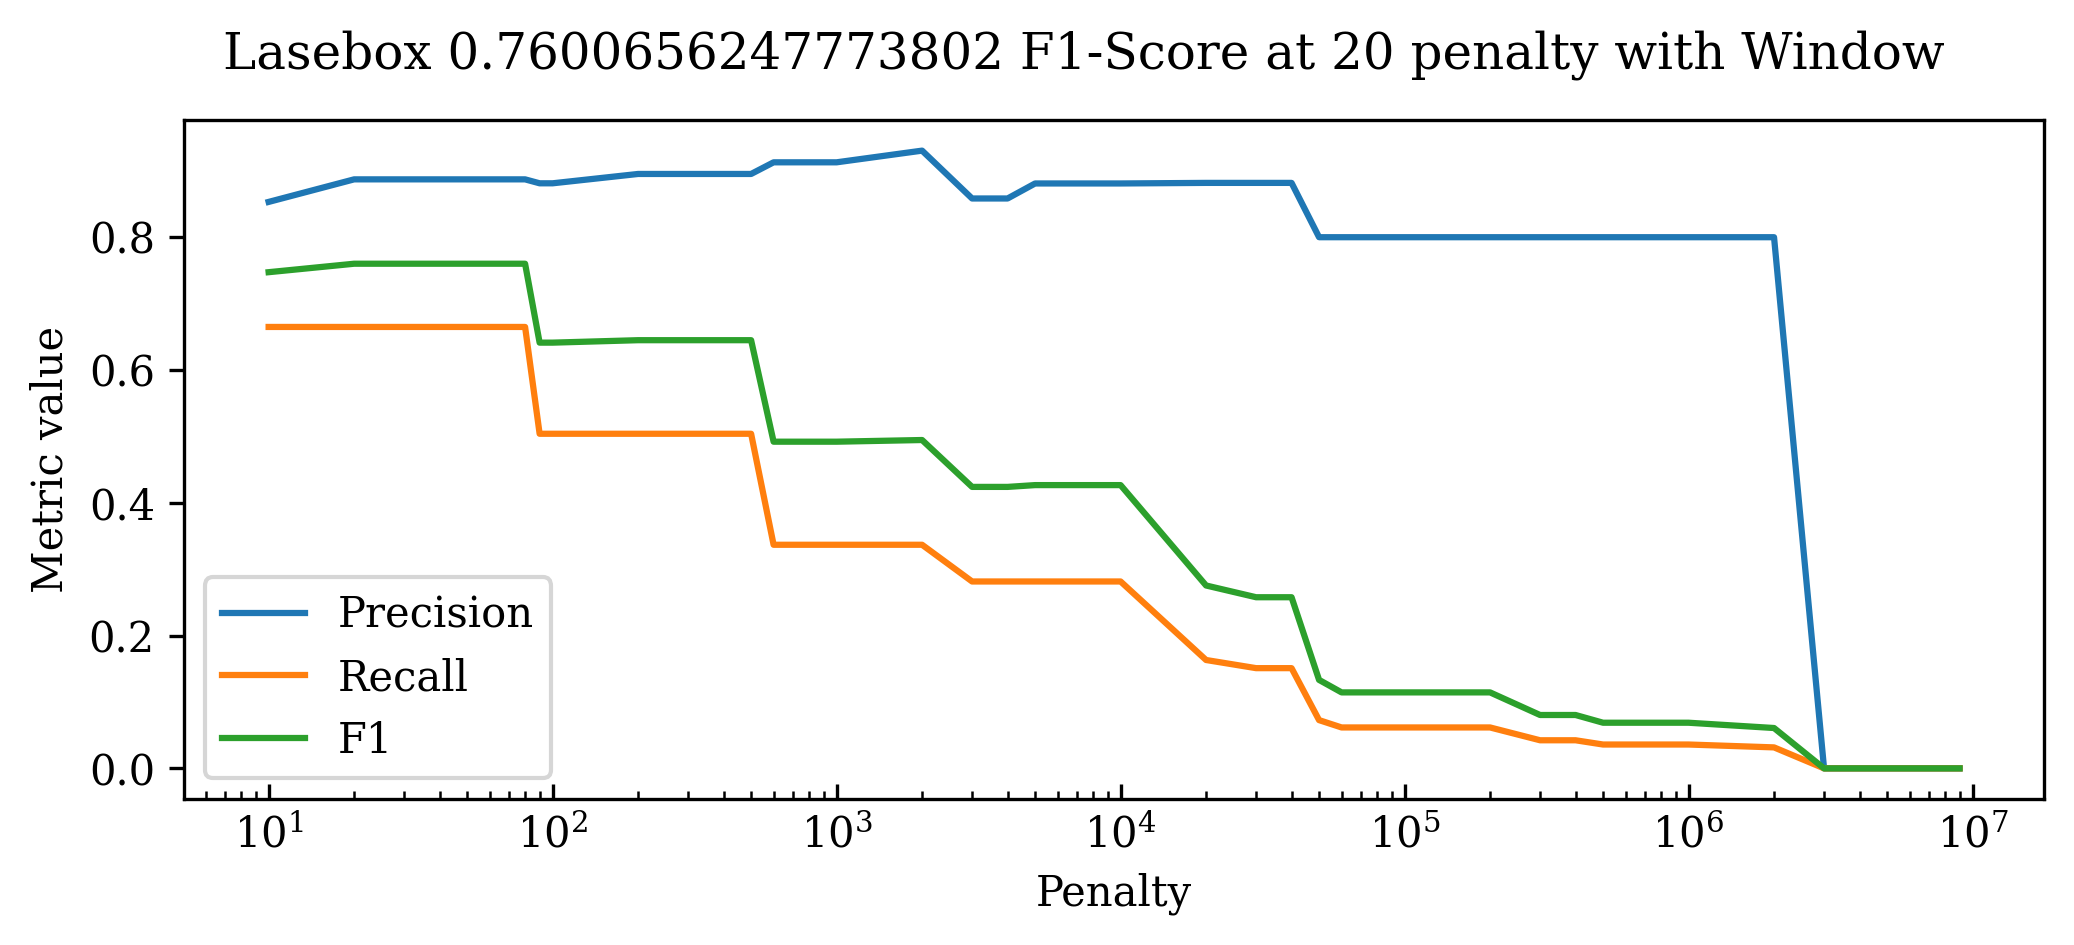

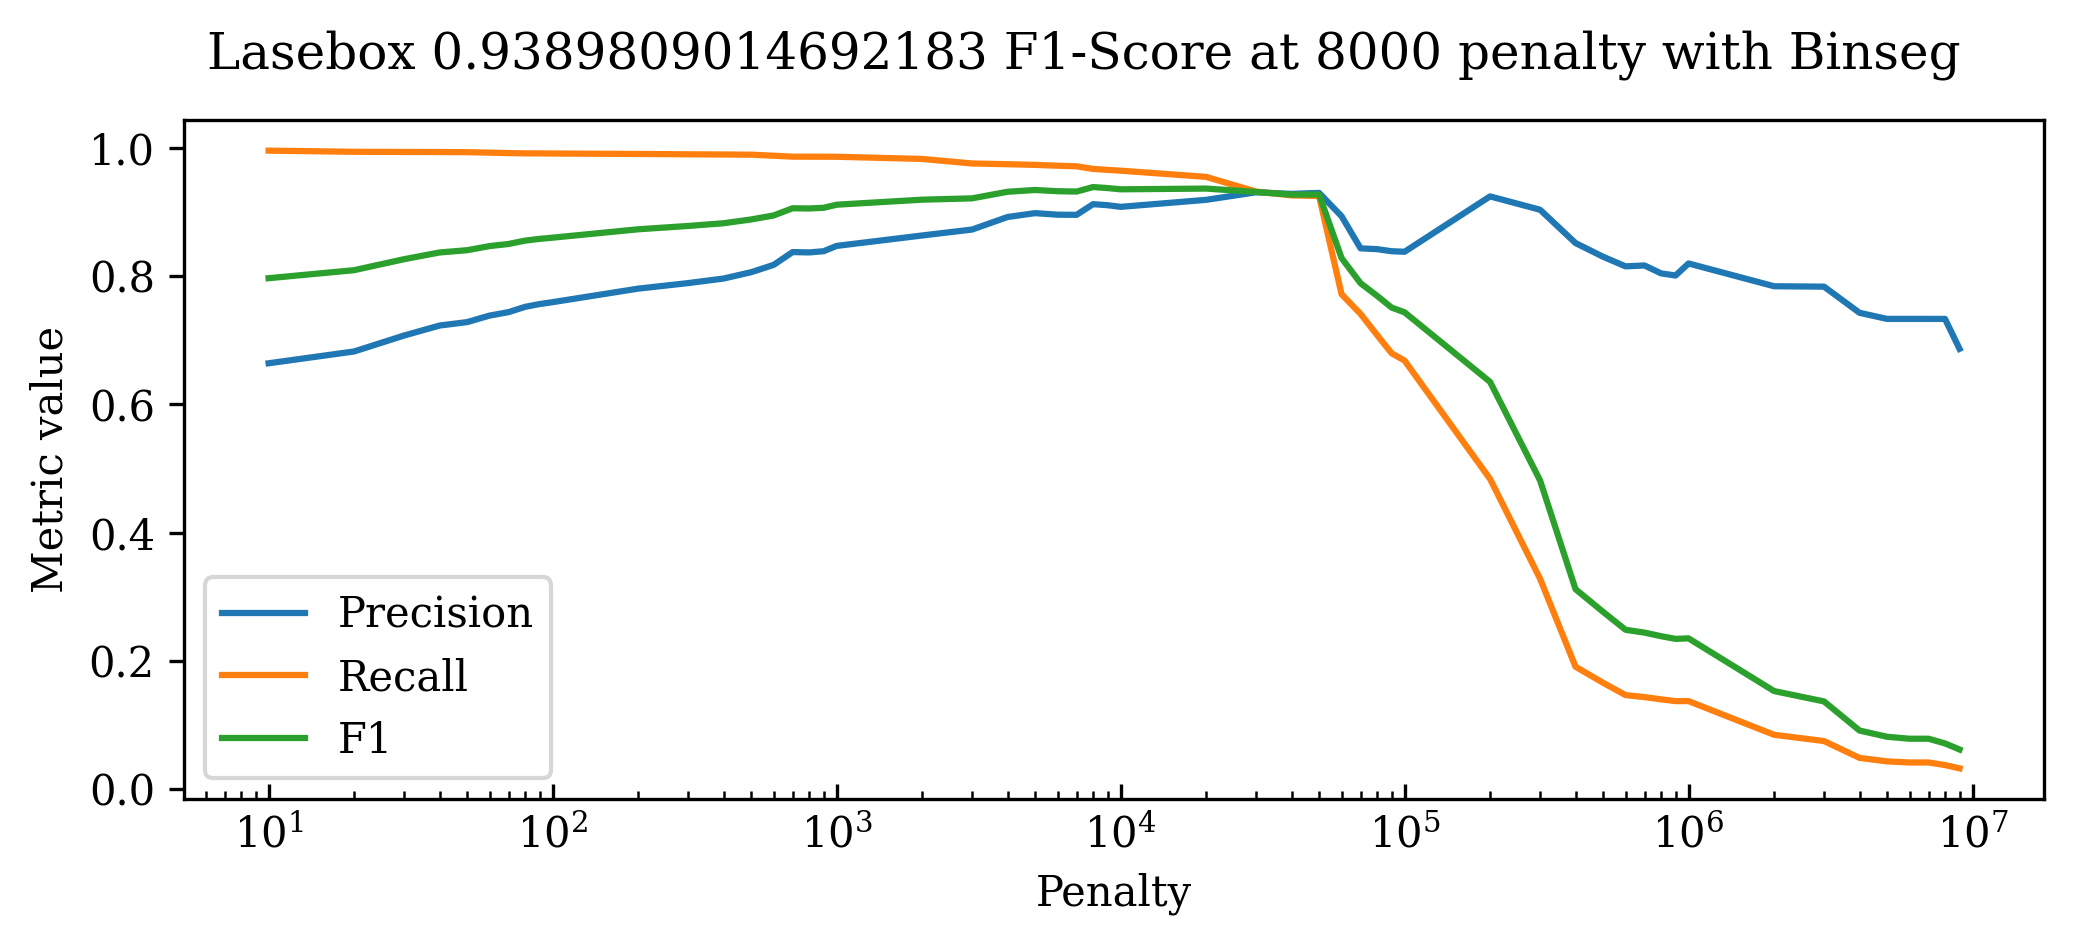

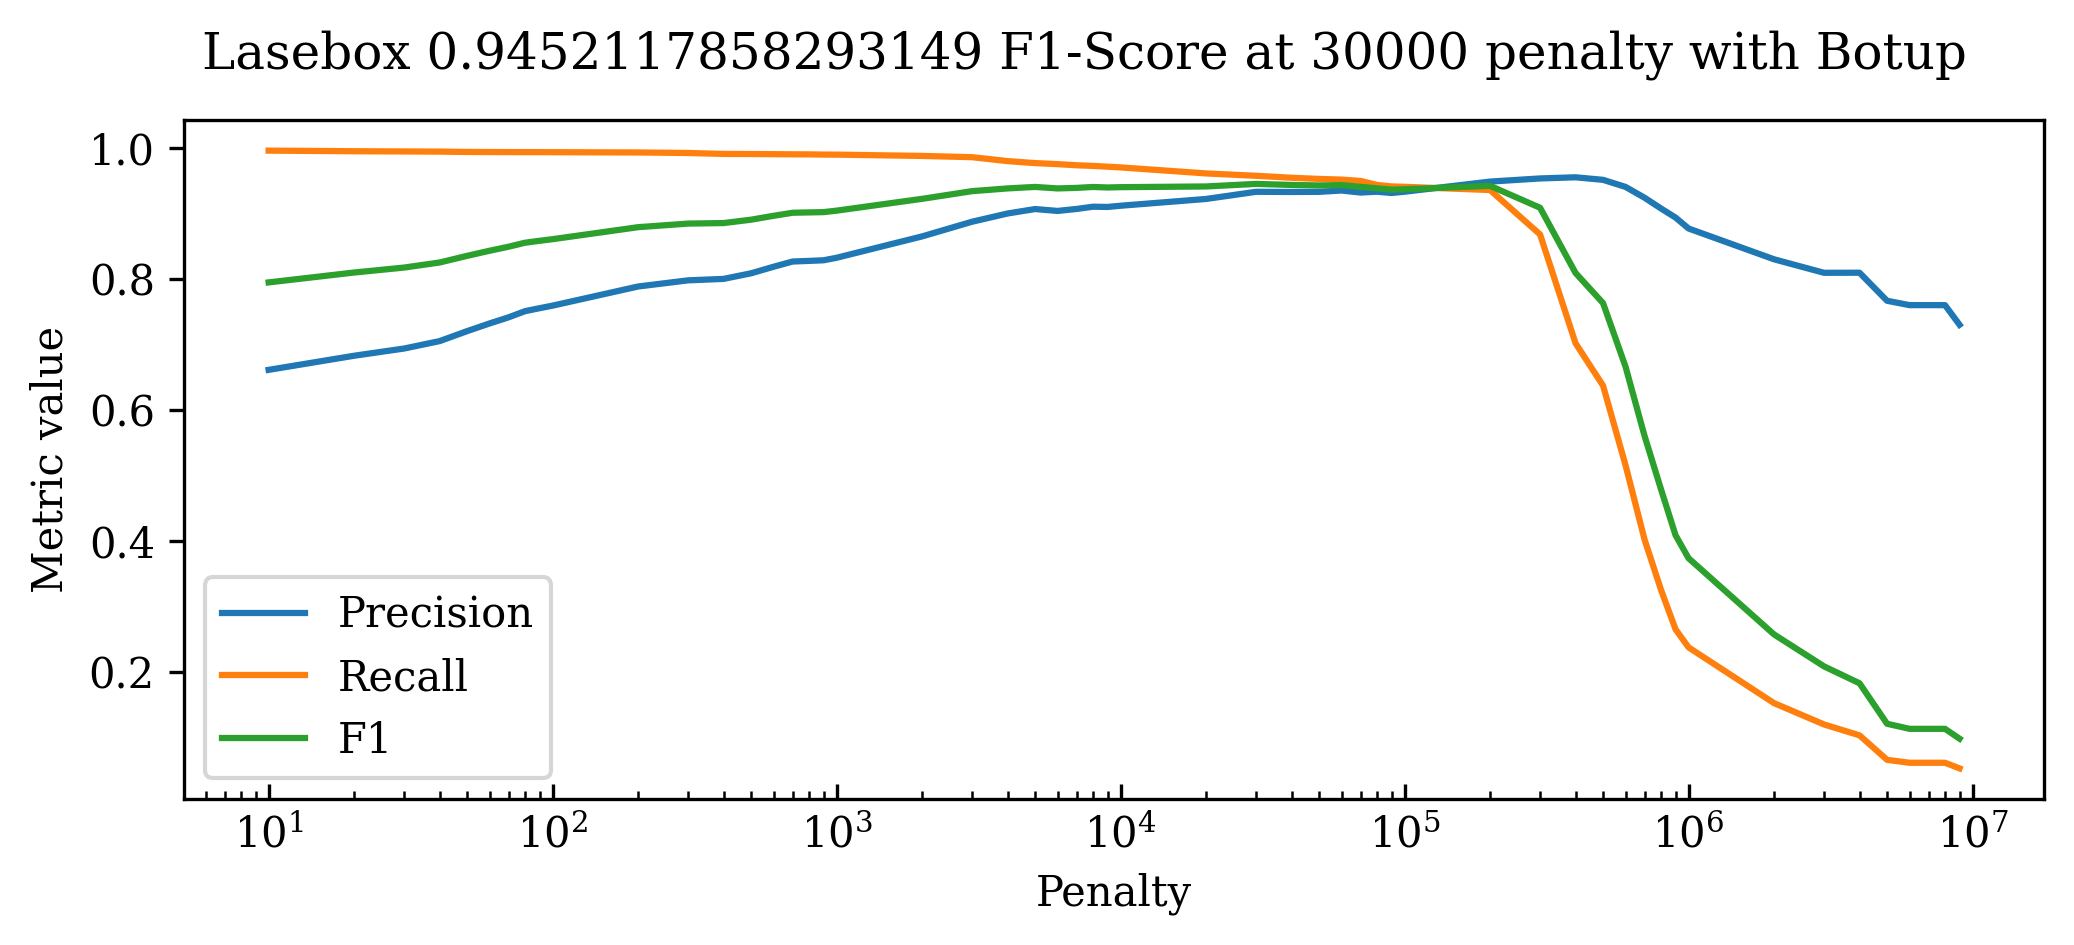

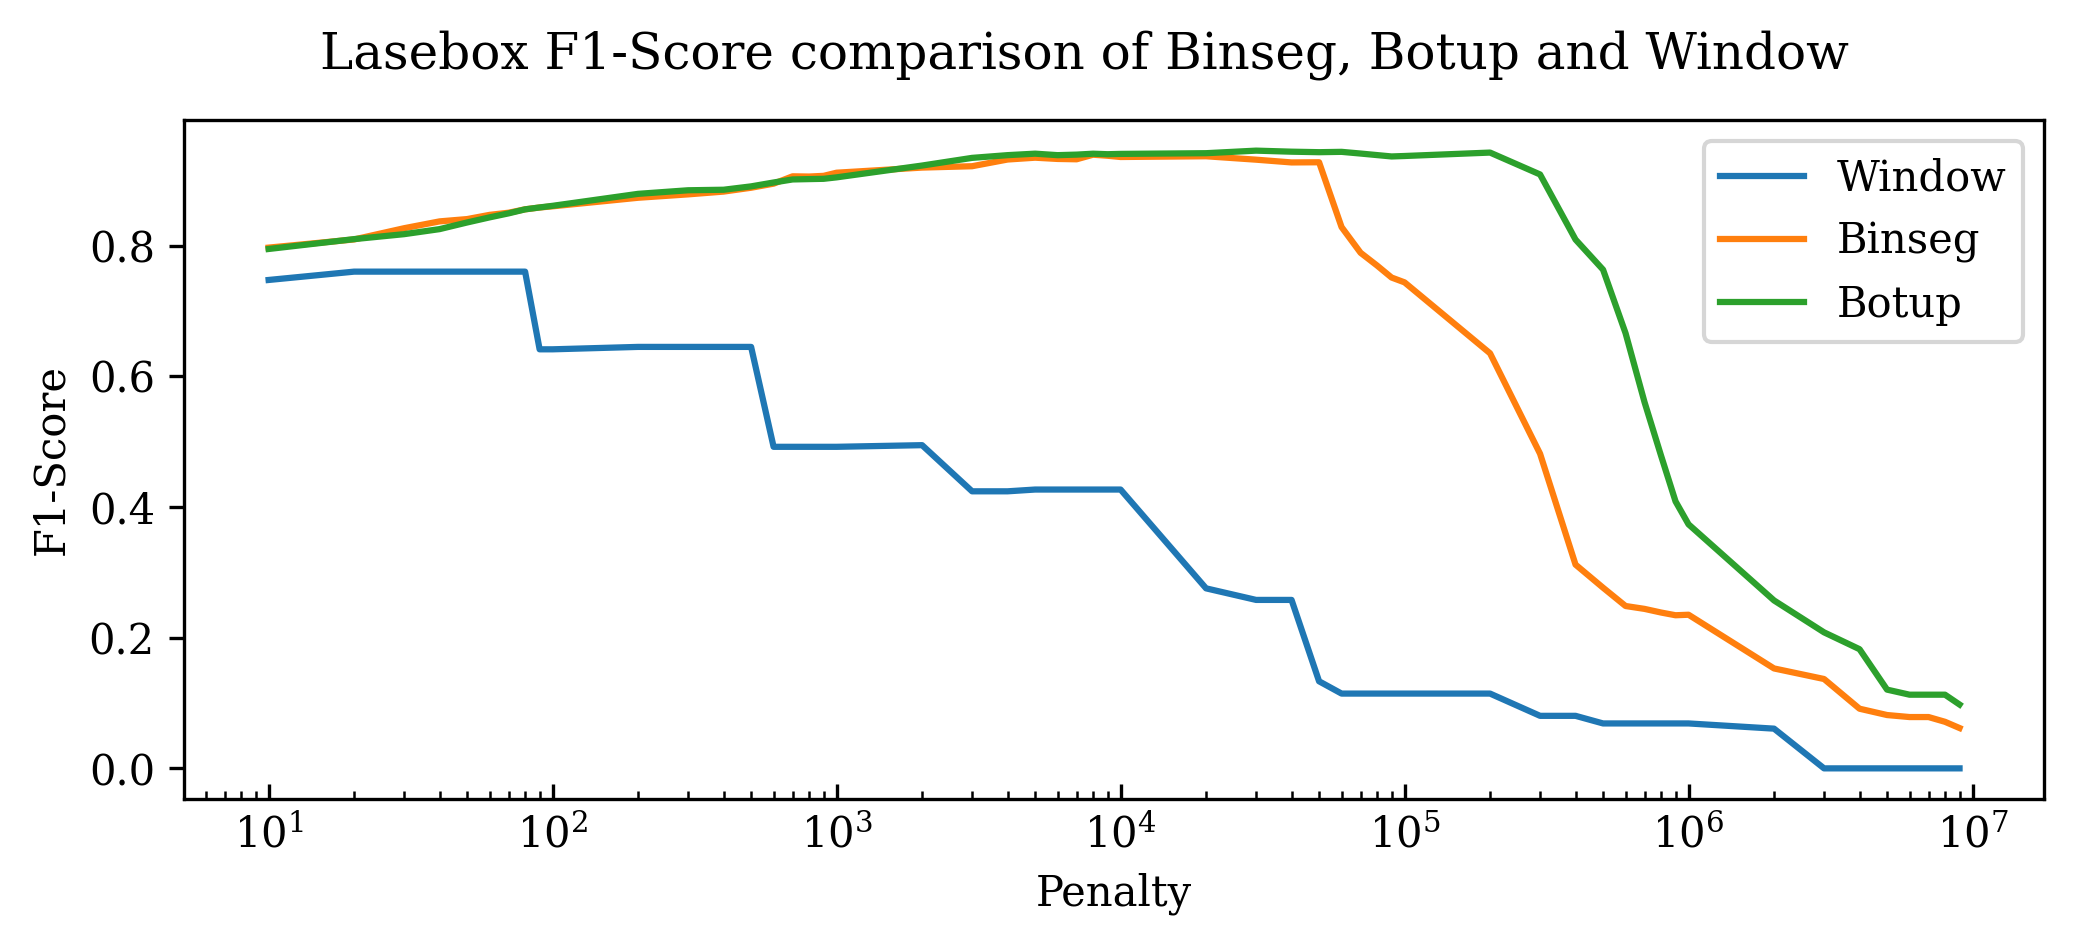

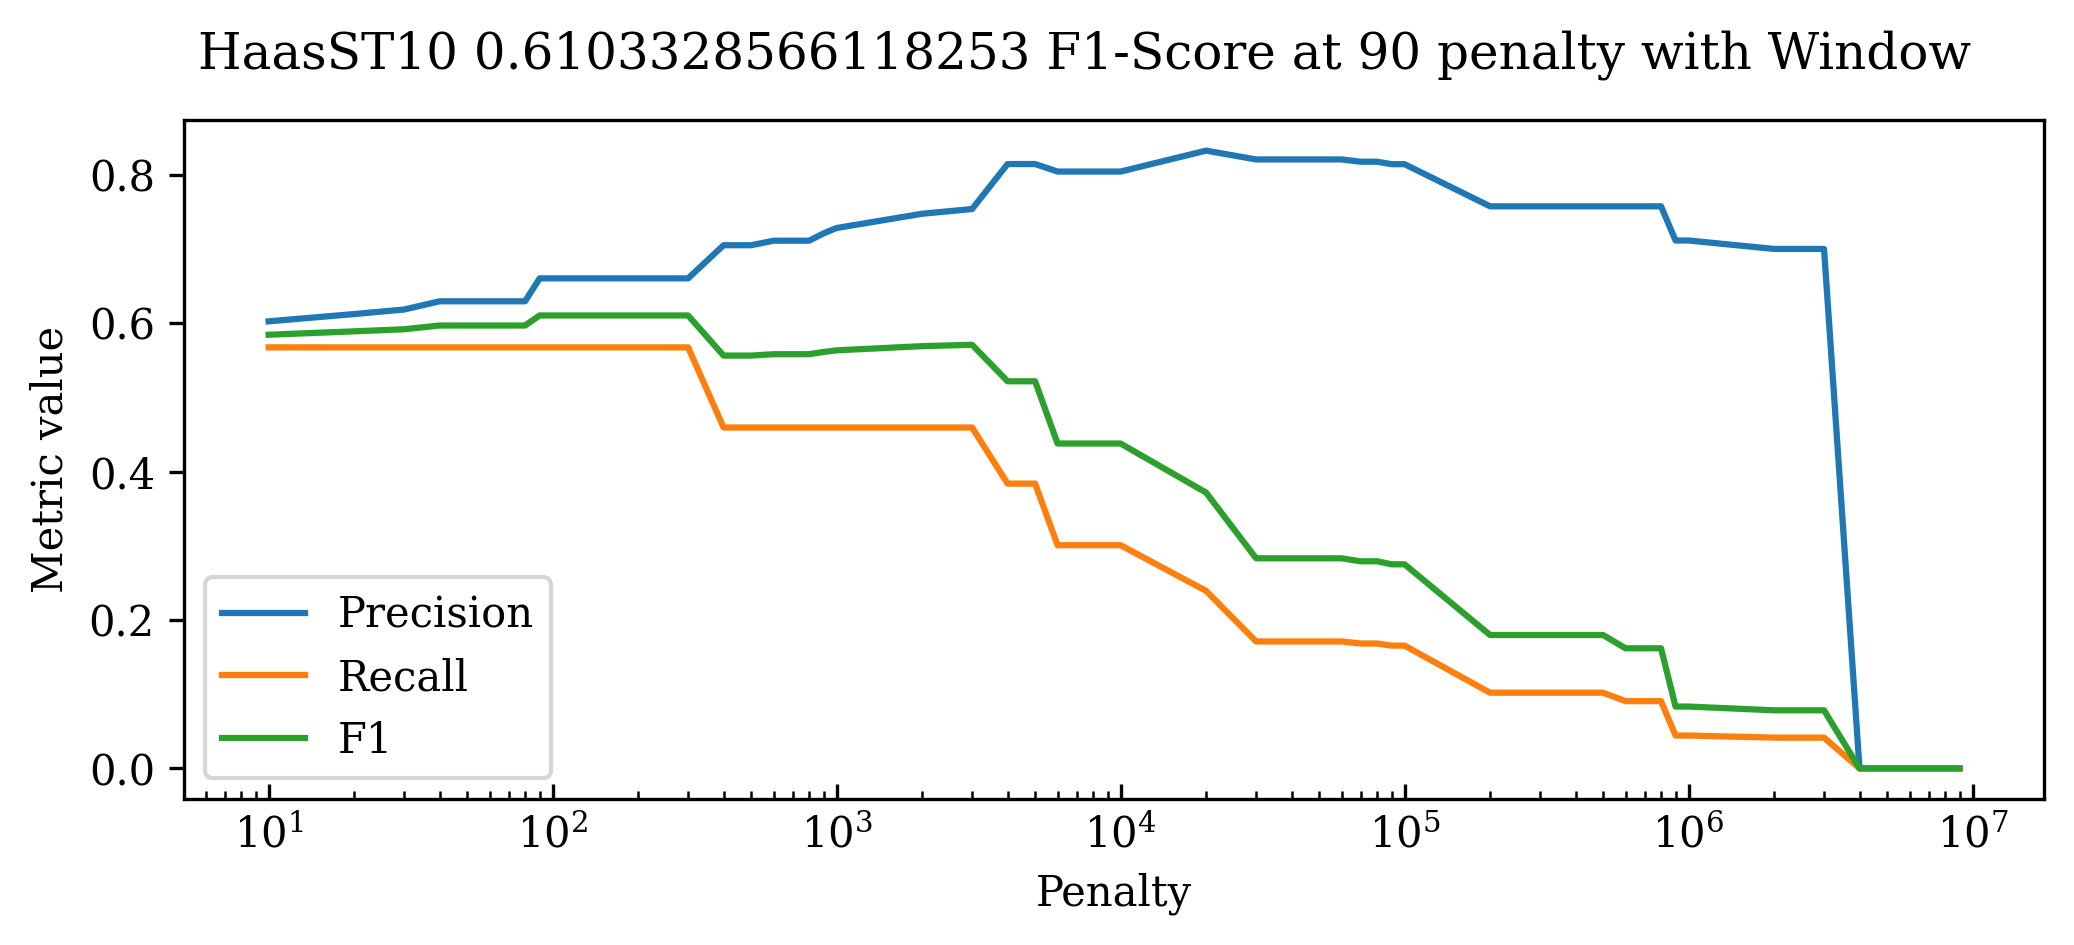

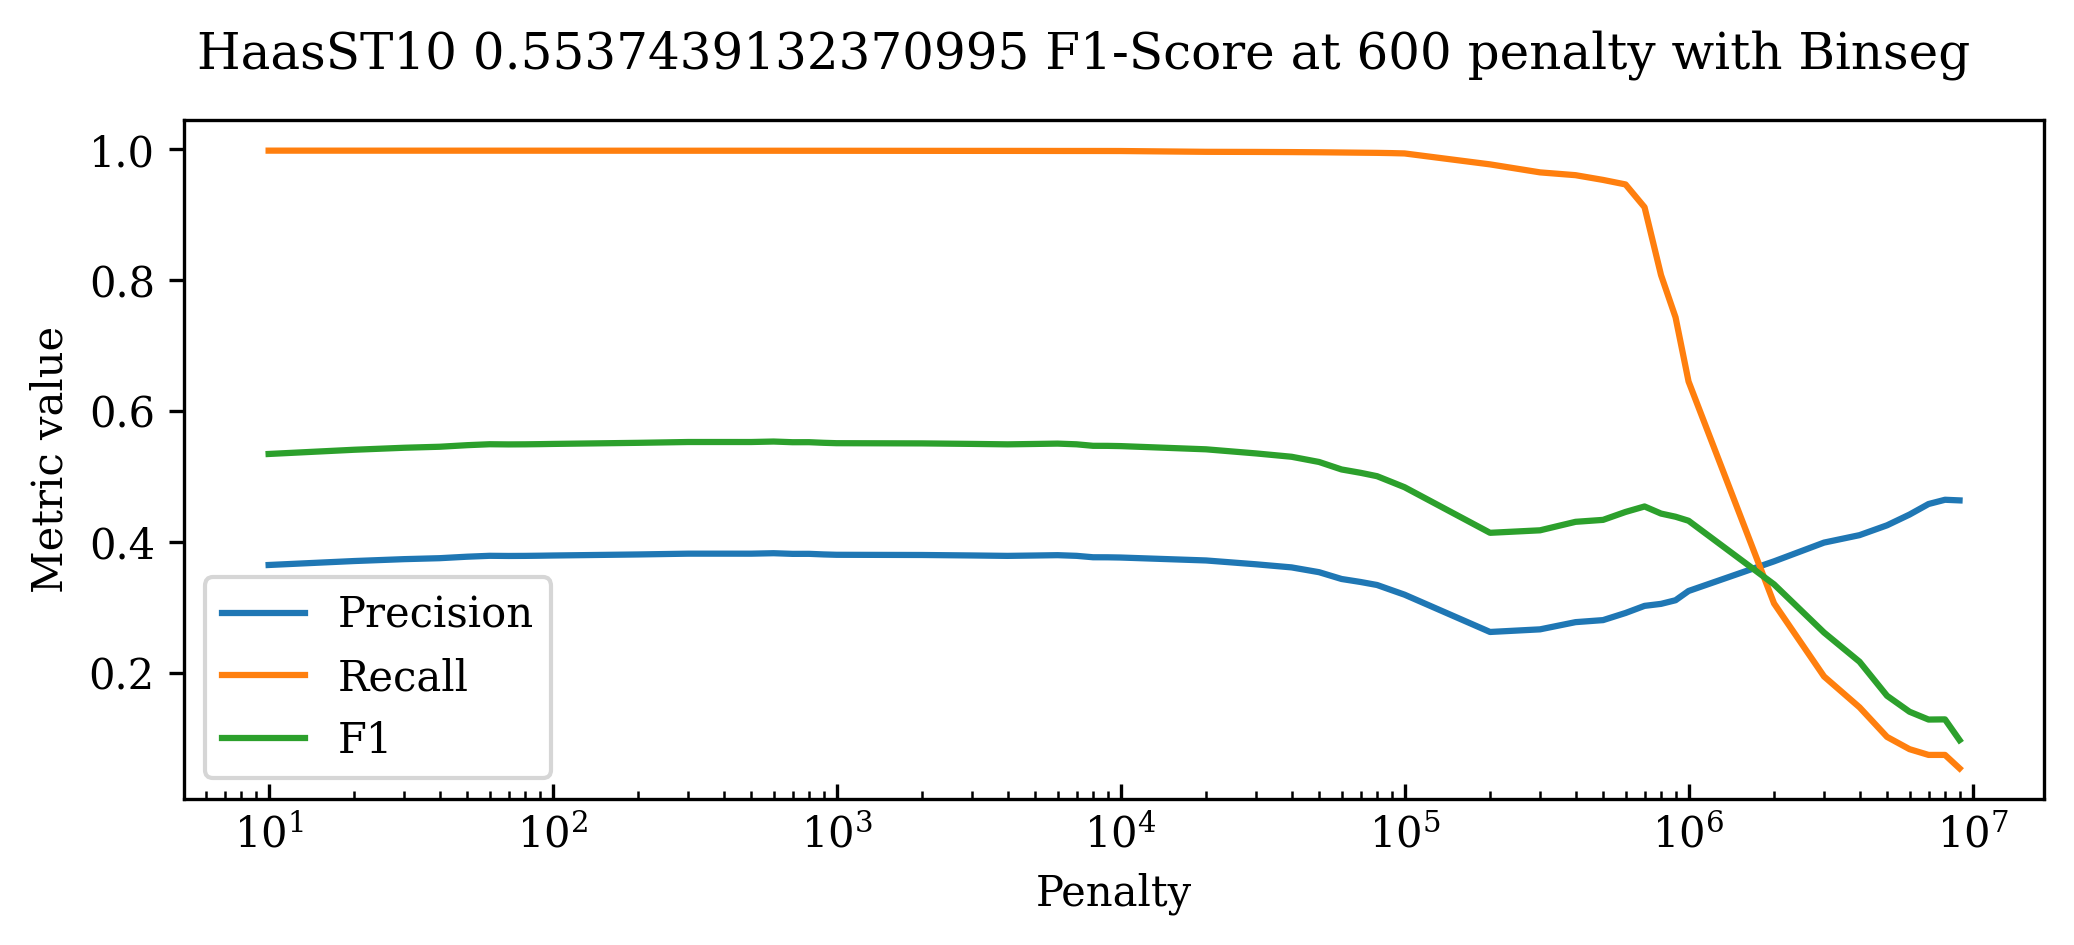

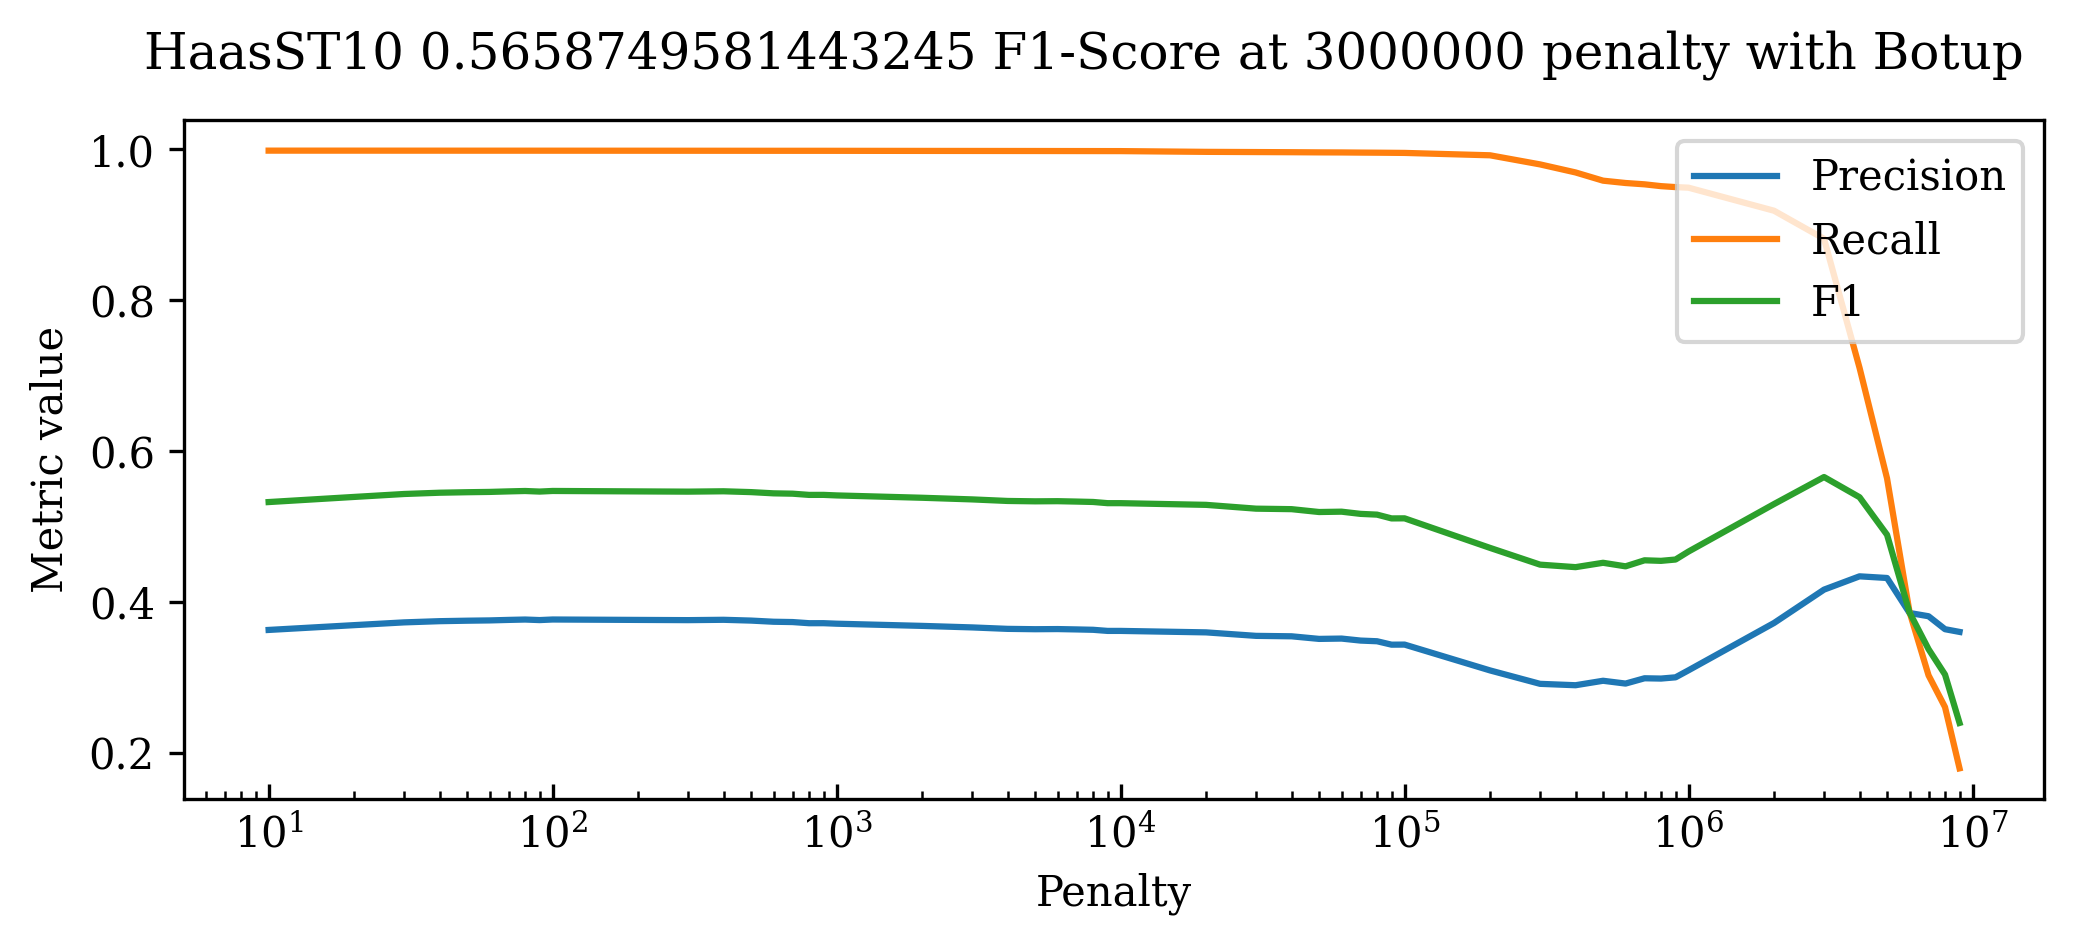

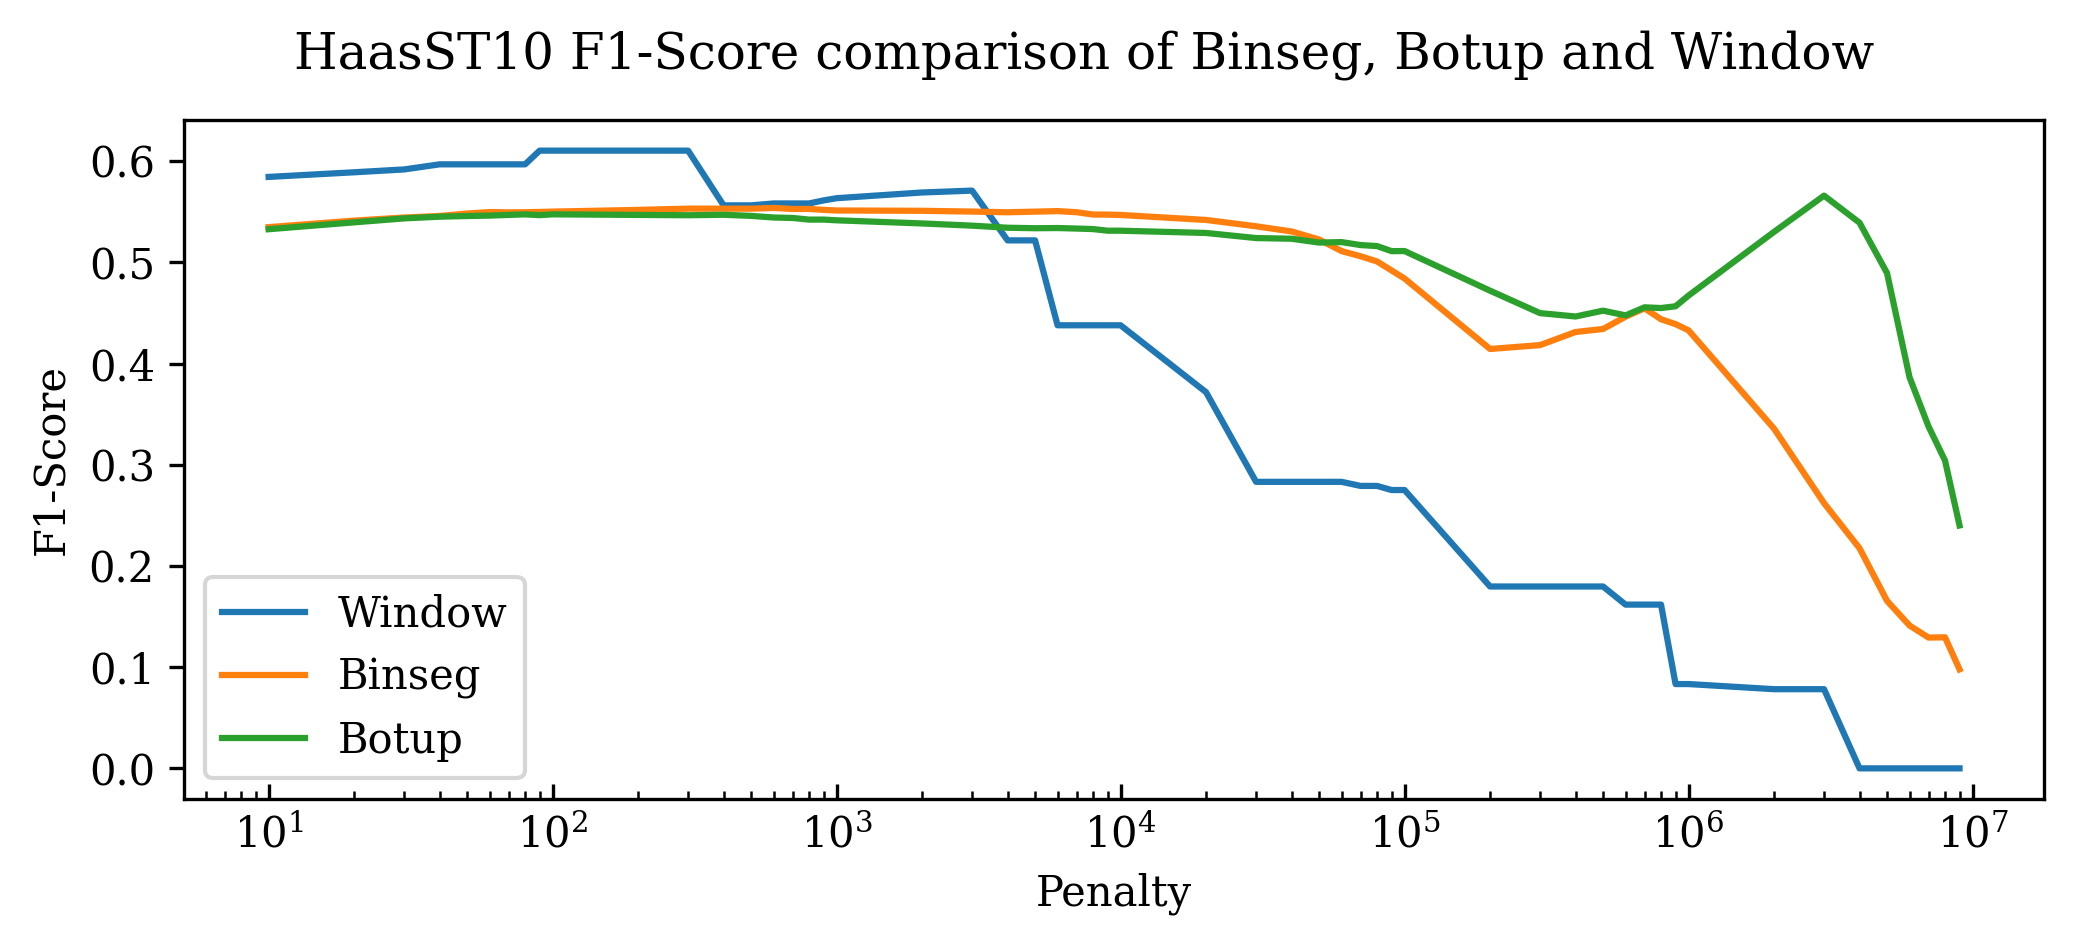

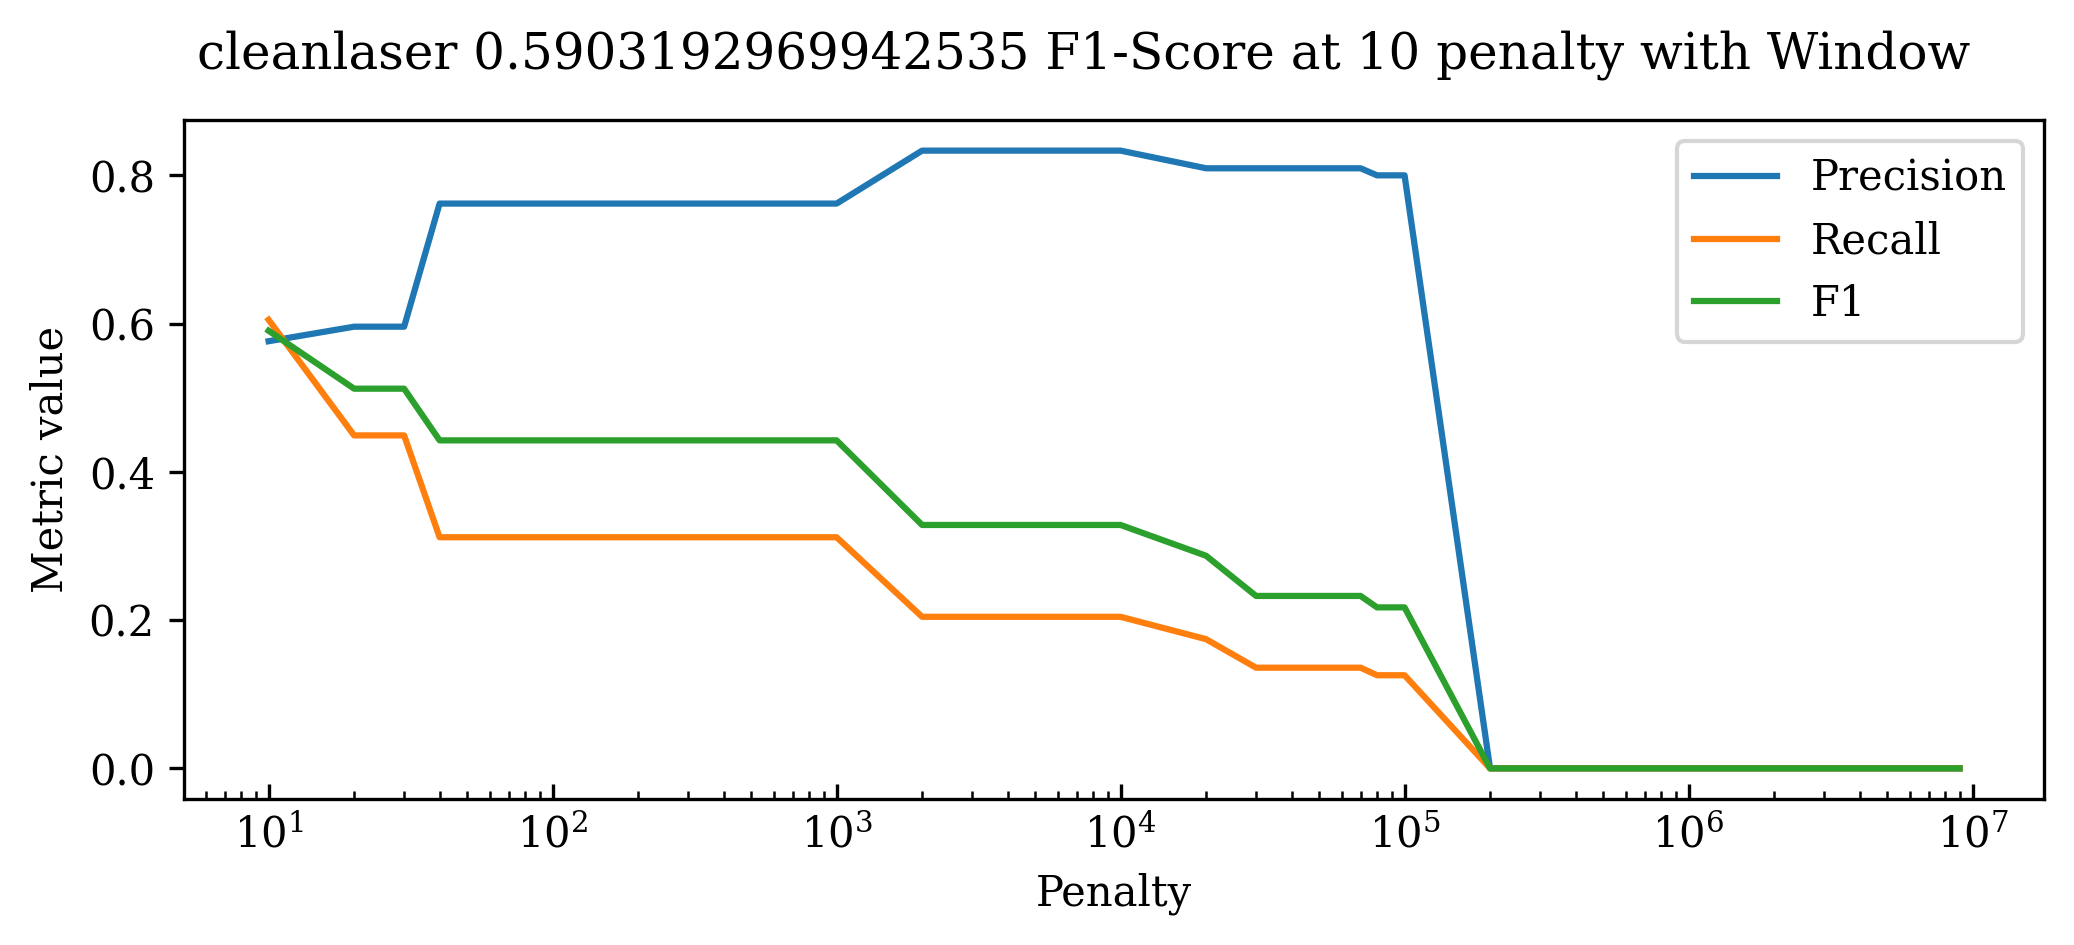

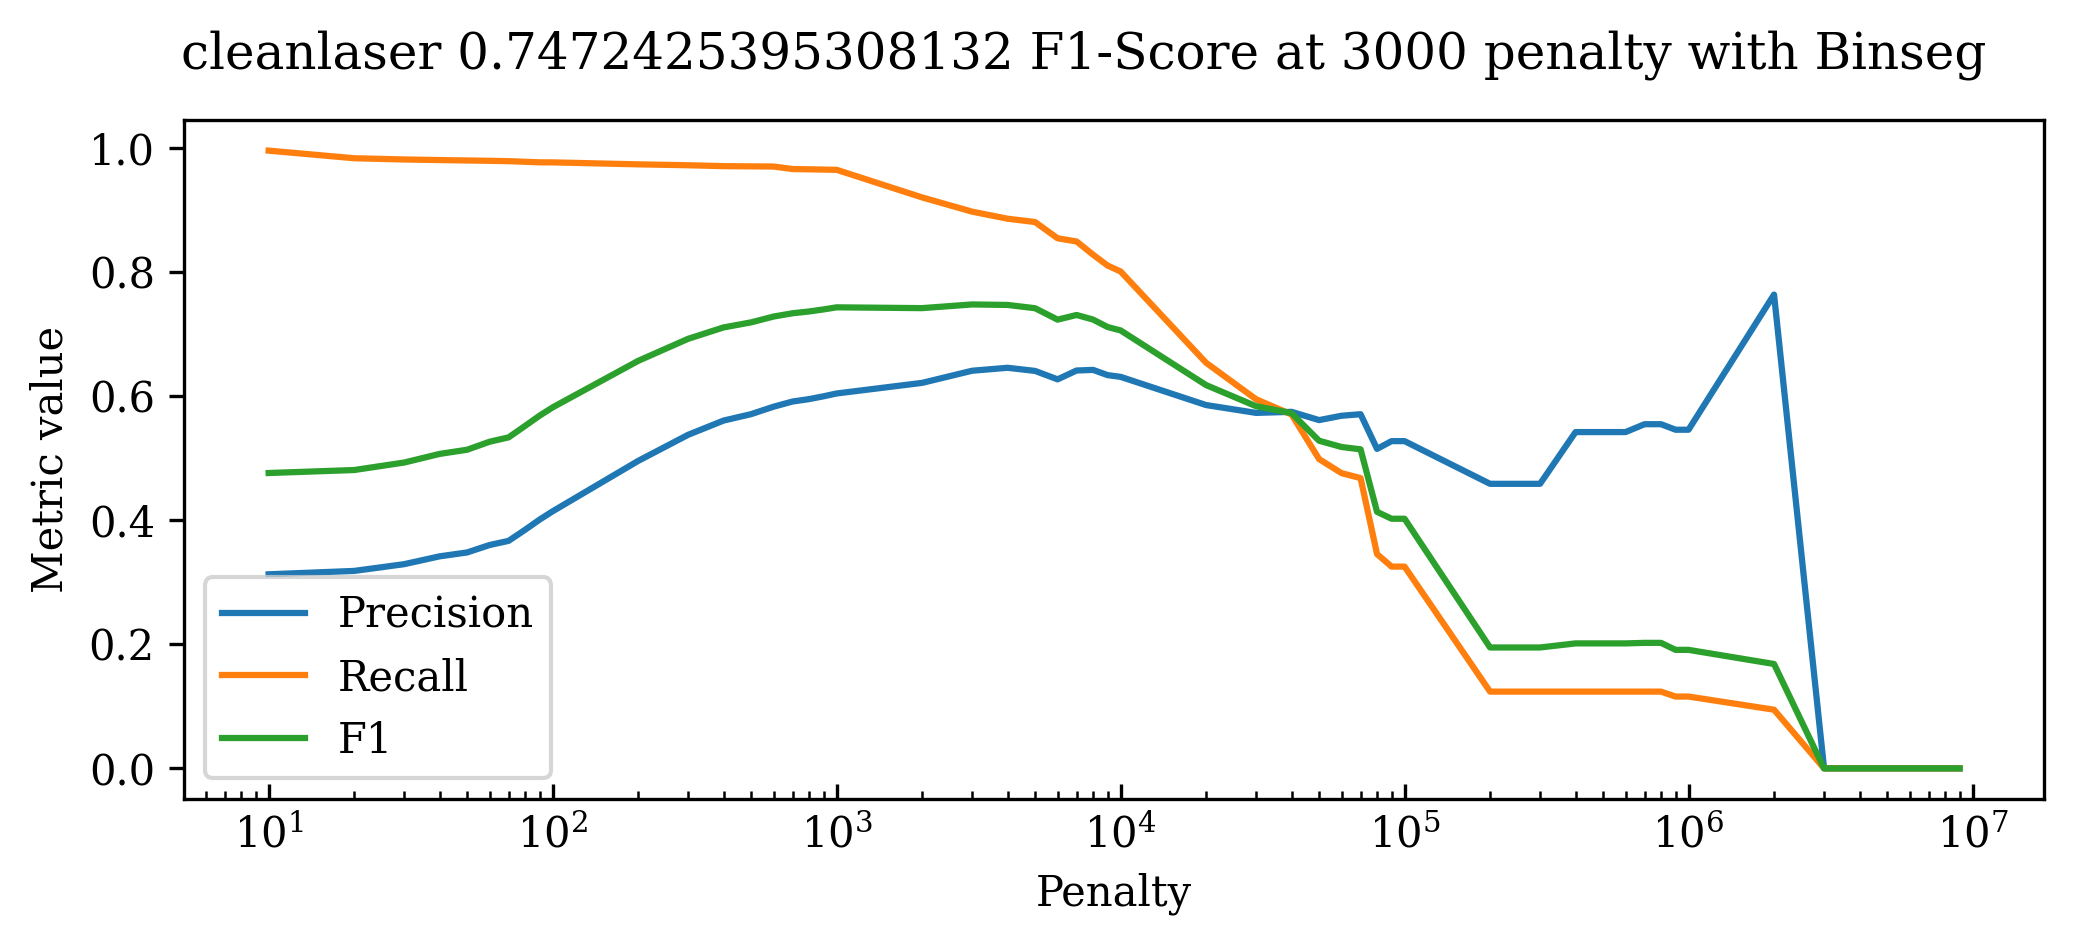

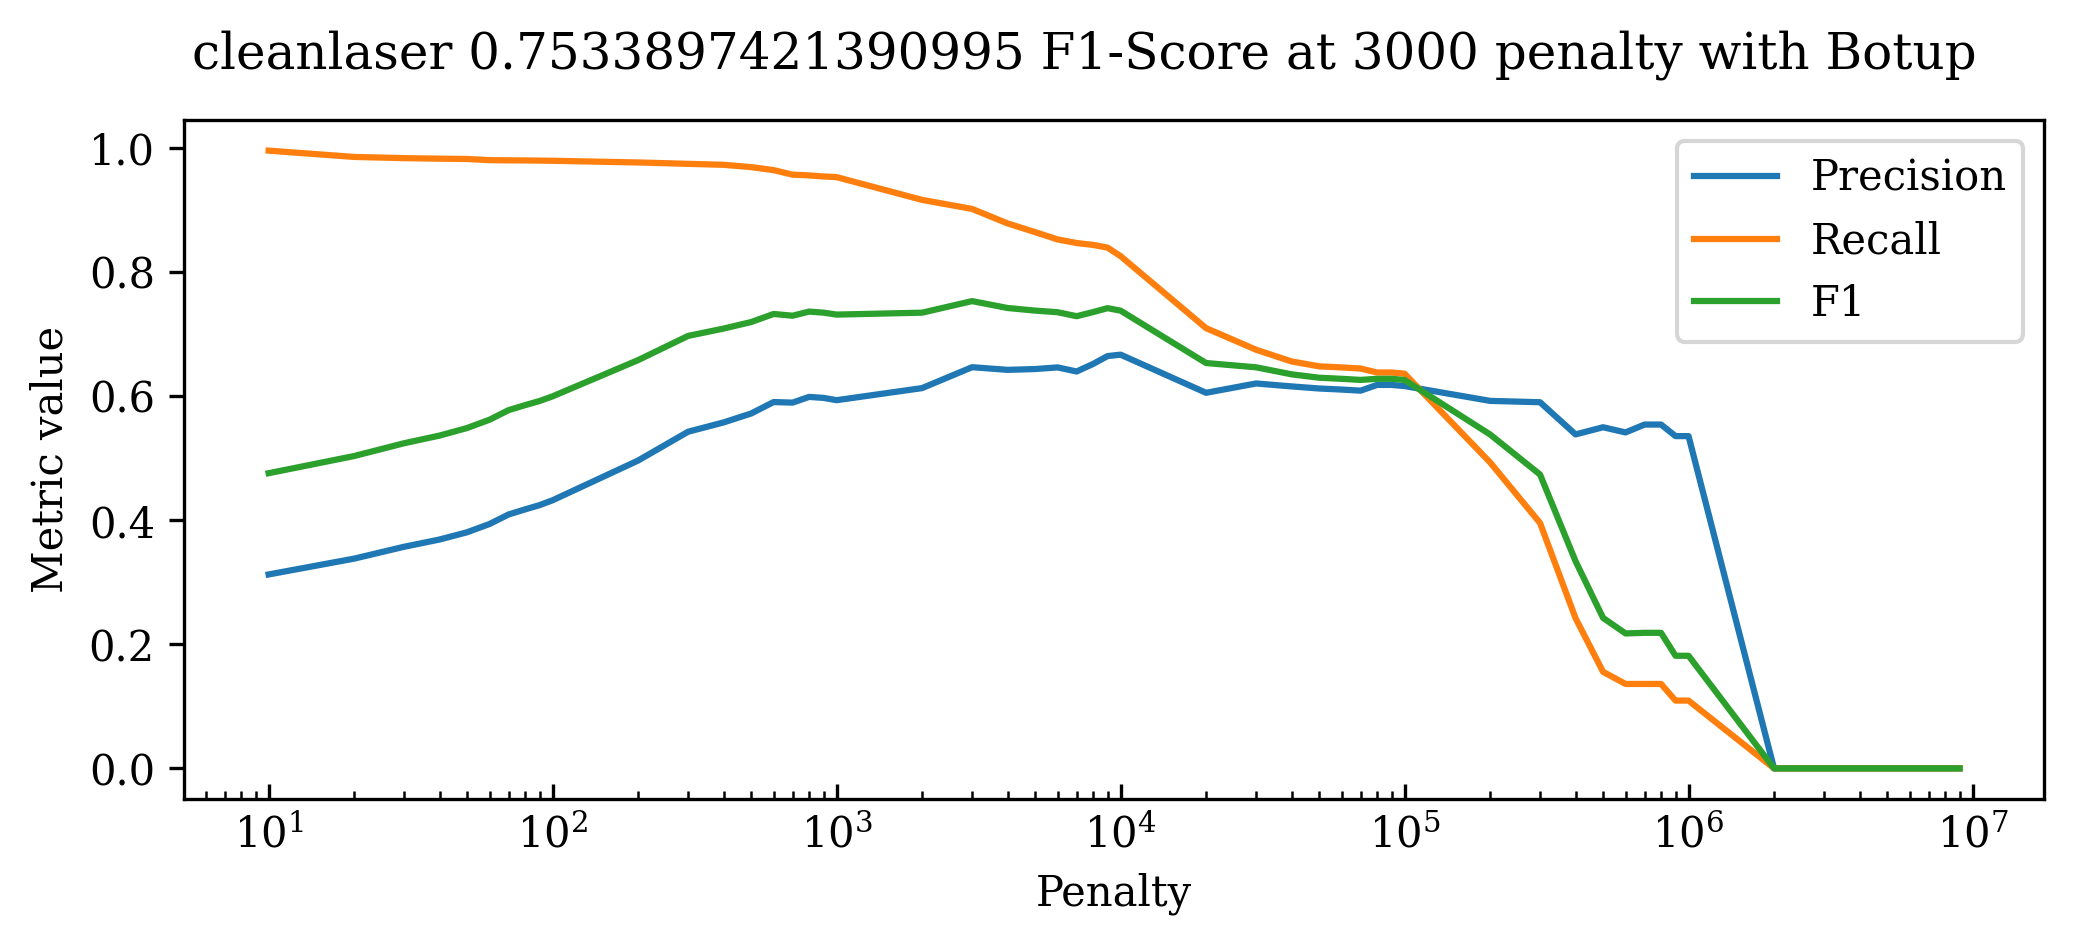

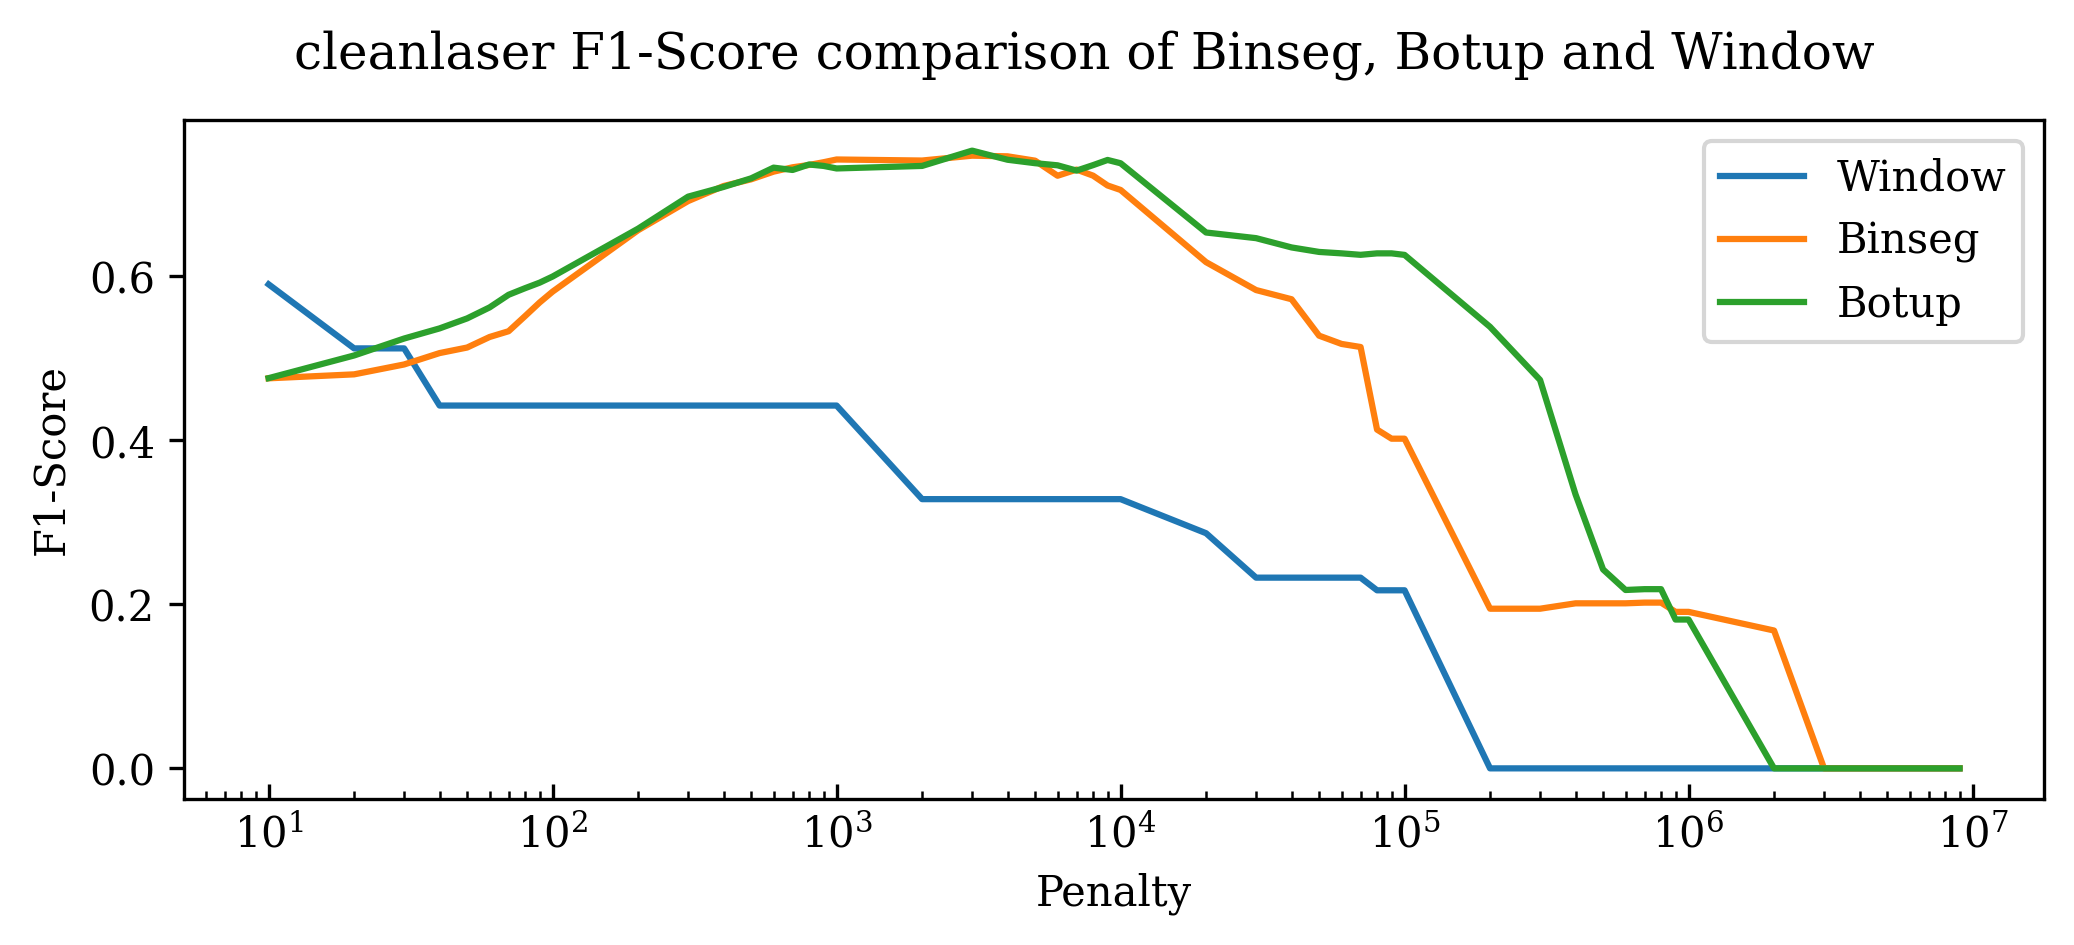

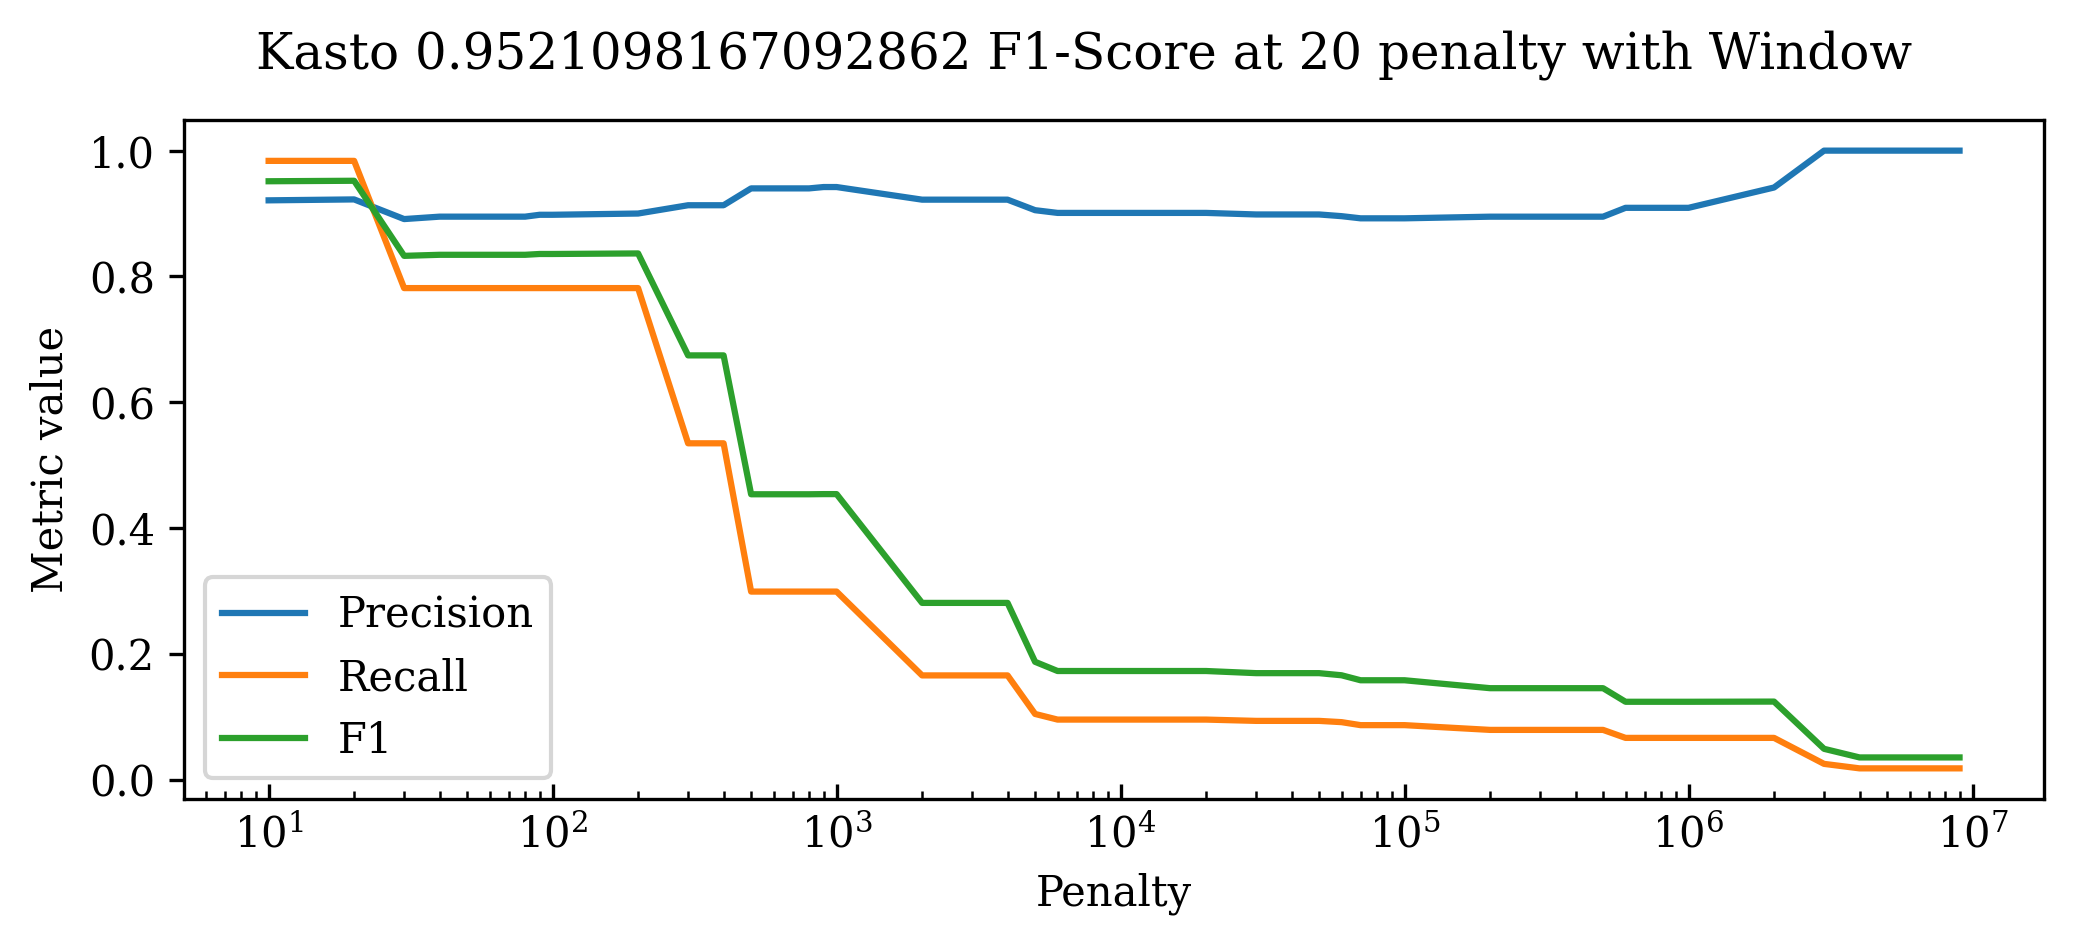

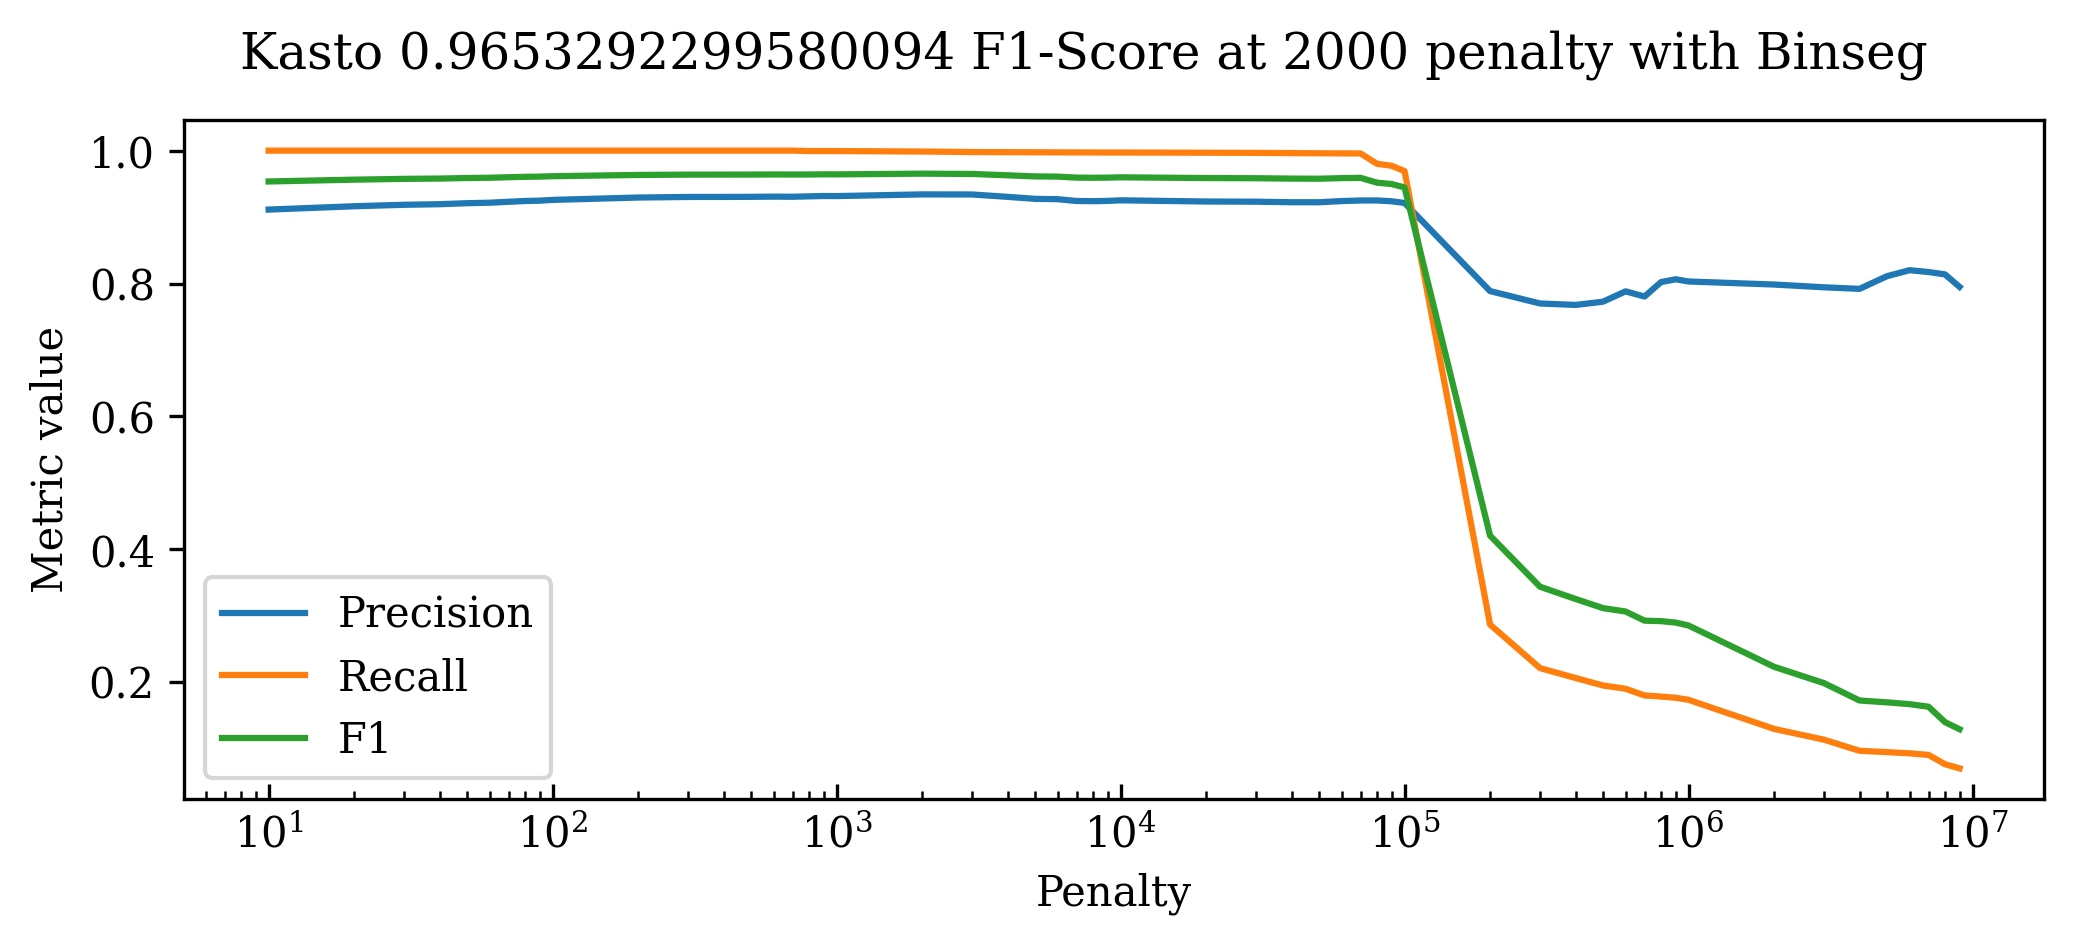

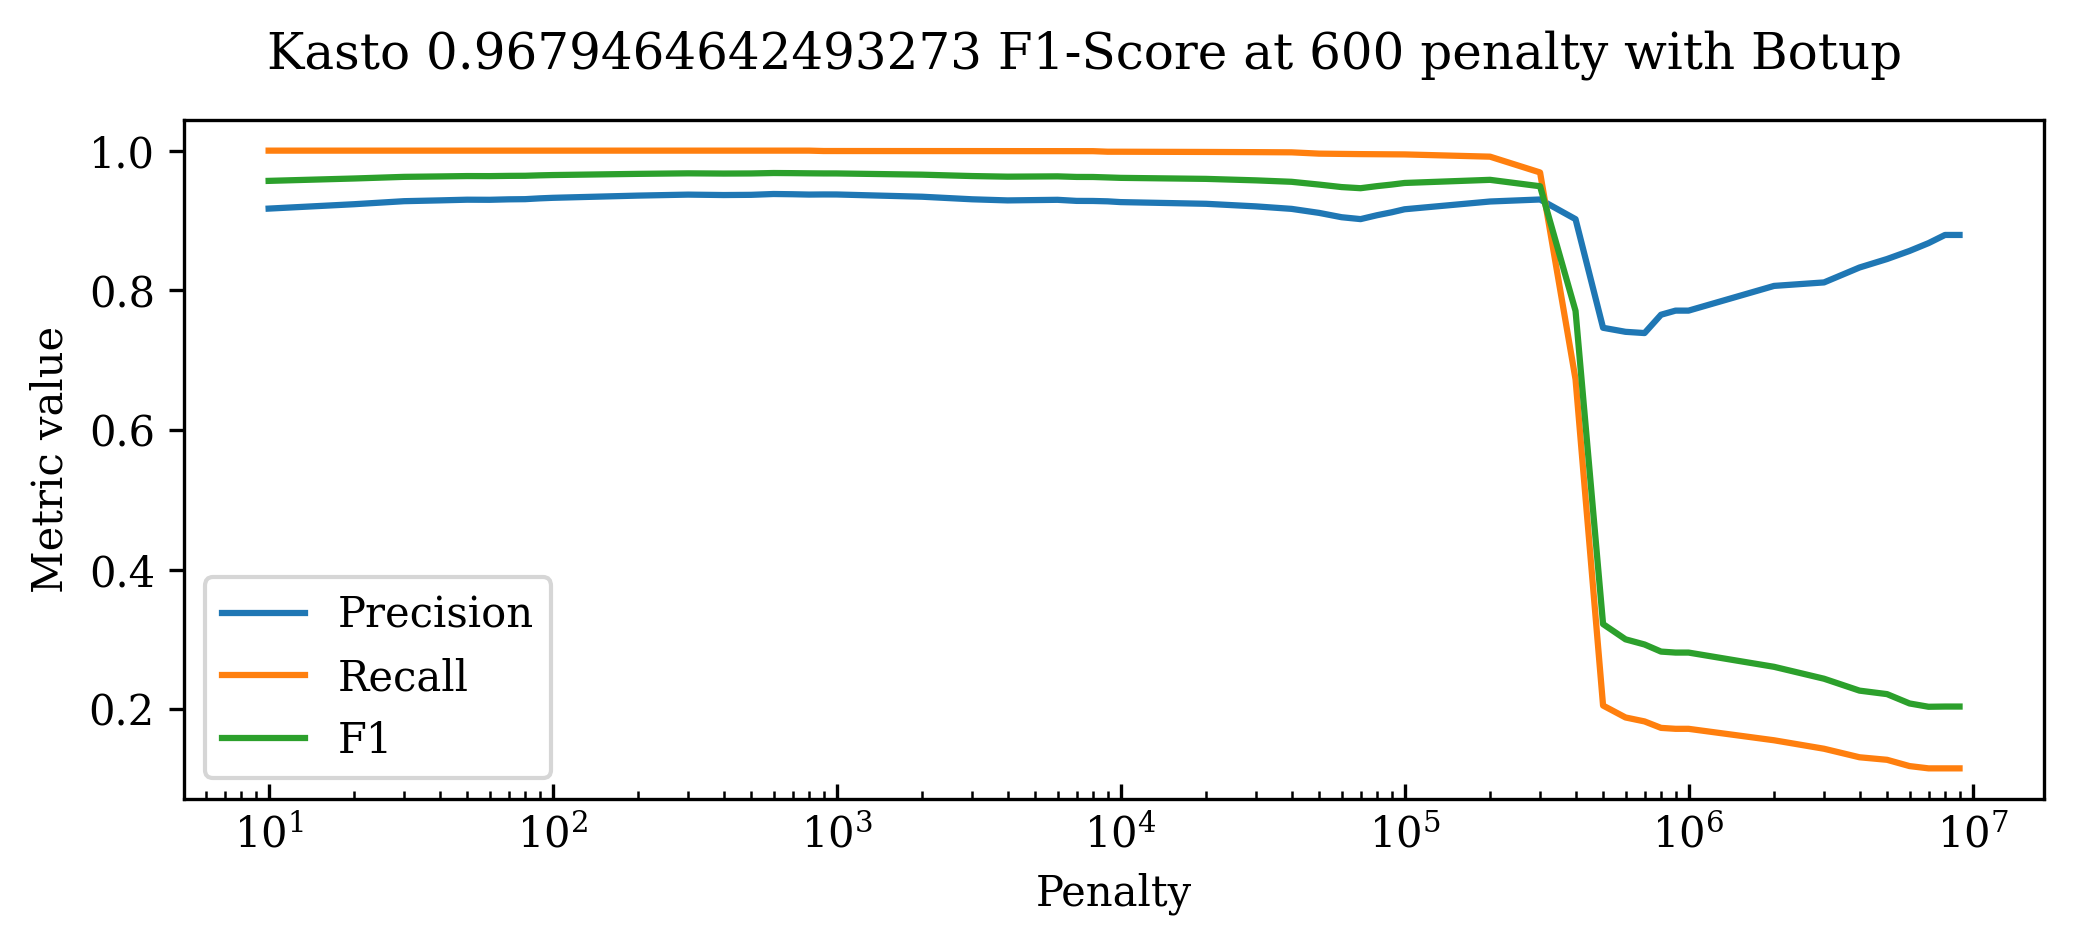

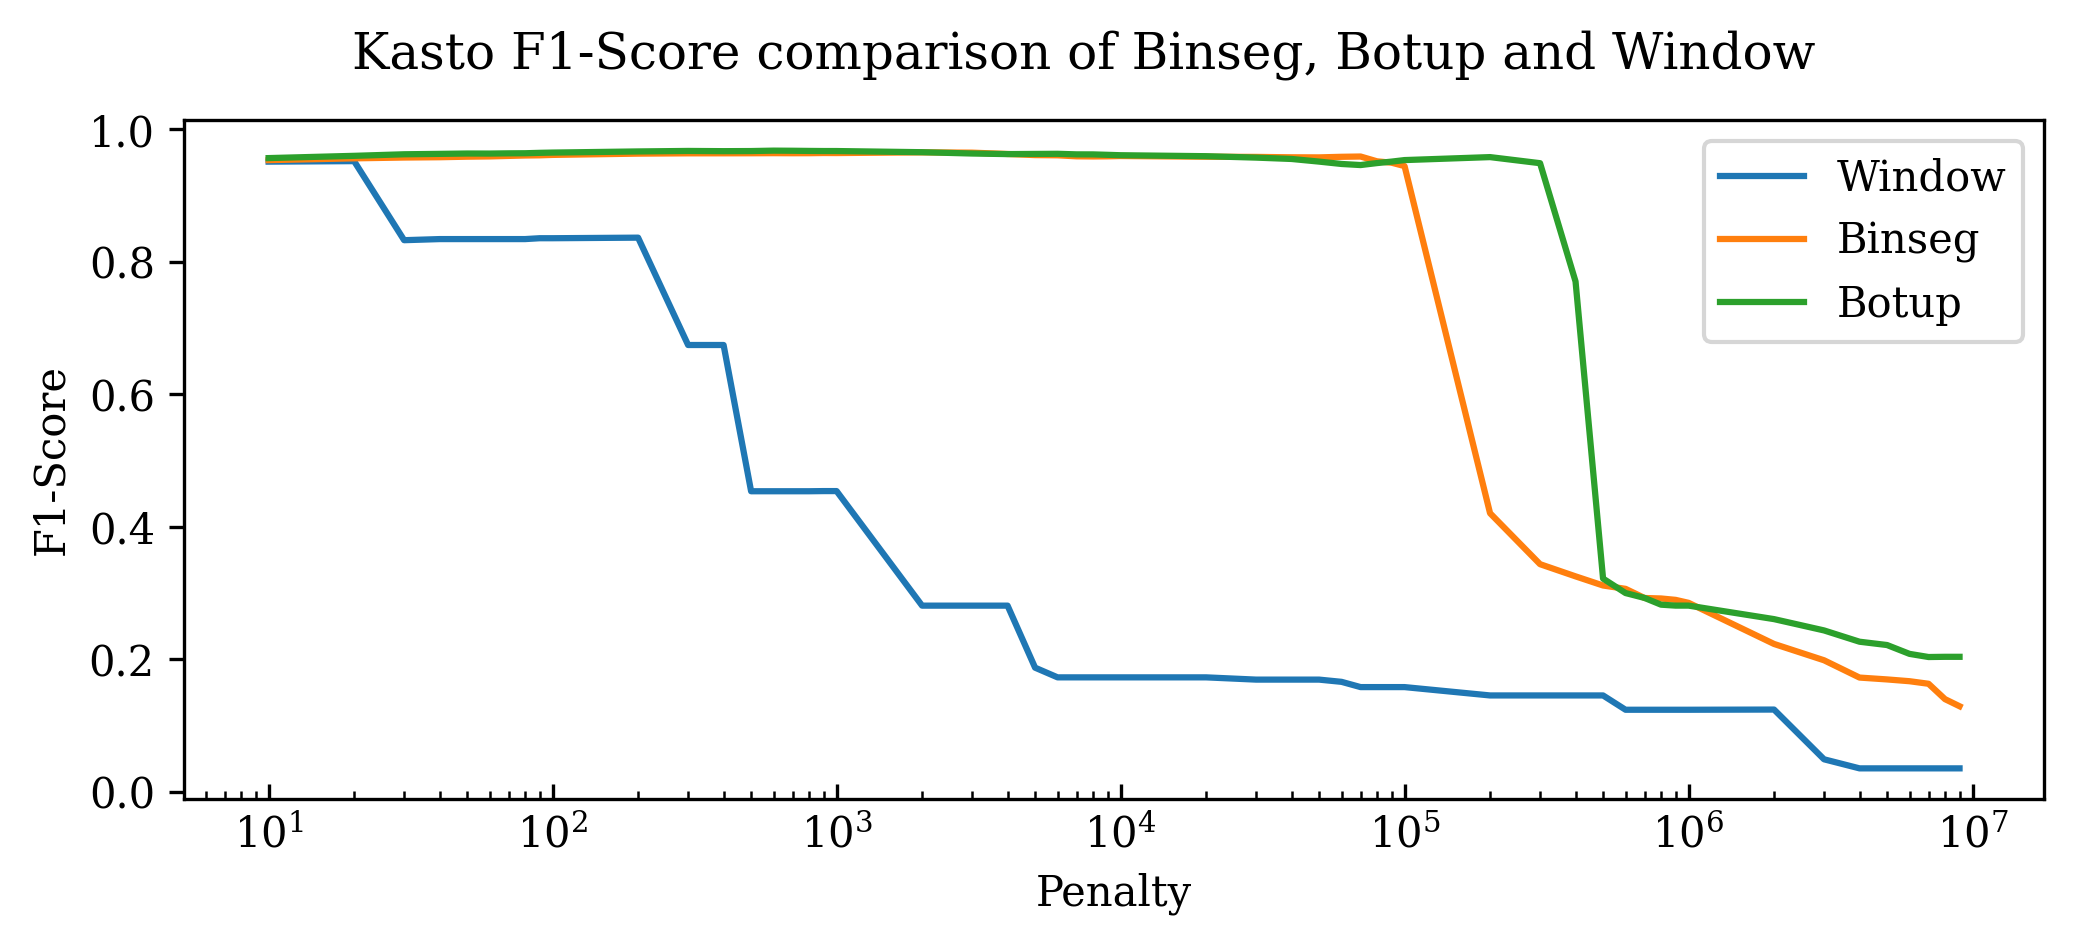

In [44]:
#for machine, window in zip(good_machines, windows):

import json

res = {}

for algo in algos:
  res[algo] = []

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  gPens = []
  f1sperAlgo = []

  for algo in algos:

    pens = []
    precs = []
    recalls = []
    f1s = []

    showbest = False

    basepen = 1
    for j in range(6):
      basepen *= 10
      for i in range(9):
        try:
          _,prec,recall = metricsMachineRuptures(machine=machine, pen=basepen + i * basepen, window=window, algo=algo, graph = False)
          totalprec = sum(prec)/len(prec)
          totalrecall = sum(recall)/len(recall)
          totalf1 = 2 * (totalprec * totalrecall) / (totalprec + totalrecall)
          pens.append(basepen + i * basepen)
          precs.append(totalprec)
          recalls.append(totalrecall)
          f1s.append(totalf1)
        except ZeroDivisionError:
          pens.append(basepen + i * basepen)
          precs.append(0)
          recalls.append(0)
          f1s.append(0)

    maxf1 = np.argmax(f1s)
    print(maxf1)

    f1sperAlgo.append(f1s)
    gPens = pens

    res[algo].append((f1s[maxf1], precs[maxf1], recalls[maxf1], pens[maxf1]))

    plt.suptitle(machine + " " + str(f1s[maxf1]) + " F1-Score at " +  str(pens[maxf1]) + " penalty with " + algo)
    plt.xlabel('Penalty')
    plt.ylabel('Metric value')
    plt.plot(pens, precs, label="Precision")
    plt.plot(pens, recalls, label="Recall")
    plt.plot(pens, f1s, label="F1")
    plt.legend()
    plt.xscale("log")
    #plt.xticks(range(len(pens)), pens, rotation=45)
    plt.savefig("./out/" + machine + algo + ".png")
    plt.show()

    if showbest:
      tests.checkPointsForMachine(name=machine, eventlog=eventLog, ids=ids, influx=False, wirkl_only=True, n_bkps=None, pen=pens[maxf1], window=window, algo=algo, model="l2", debug=True)
  
  # Compare Algos on Machine
  plt.suptitle(machine + " " + "F1-Score comparison of Binseg, Botup and Window")
  plt.xlabel('Penalty')
  plt.ylabel('F1-Score')
  for algoIdx in range(len(algos)):
    plt.plot(gPens, f1sperAlgo[algoIdx], label=algos[algoIdx])
  plt.legend()
  plt.xscale("log")
  #plt.xticks(range(len(pens)), pens, rotation=45)
  plt.savefig("./out/" + machine + ".png")
  plt.show()

with open("out/res.json", "w") as outfile:
  json.dump(res, outfile)

In [38]:
print(res)

{'Window': [(0.9521098167092862, 0.9224575922266139, 0.9837316853014975, 20)], 'Binseg': [(0.9653292299580094, 0.9341456309766805, 0.9986666666666667, 2000)], 'Botup': [(0.9679464642493273, 0.9378839669836346, 1.0, 600)]}


In [ ]:
import json

res = {}

with open("out/res.json", "r") as infile:
  res = json.load(infile)


good_machines = ["HaasMM2", "Lasebox", "HaasST10", "cleanlaser", "Kasto"]
windows = [35, 20, 35, 35, 20]
algos = ["Window", "Binseg", "Botup"]

for ix in range(len(good_machines)):
  machine = good_machines[ix]
  window = windows[ix]
  gPens = []
  f1sperAlgo = []

  for algo in algos:
    print("lolololol doch nicht")